# 03 - Clustering: K-Means e DBSCAN

## CRISP-DM: Fase de Modelação - Experiência 1 (Aprendizagem Não Supervisionada)

Este notebook implementa algoritmos de **clustering** para identificar perfis de
consumidores no dataset D4Maia, seguindo a metodologia CRISP-DM.

### Objetivos:
1. **K-Means**: Identificar grupos de consumidores com base em features agregadas
2. **DBSCAN**: Detetar outliers e clusters de forma não paramétrica
3. **Normalização**: Avaliar impacto da normalização nos clusters
4. **Caracterização**: Interpretar perfis de consumo (diurno, noturno, 24/7, etc.)

### Métricas de Avaliação:
- **Silhouette Score**: Mede a qualidade da separação dos clusters [-1, 1]
- **Calinski-Harabasz Index**: Rácio de dispersão inter/intra clusters
- **Davies-Bouldin Index**: Média das semelhanças entre clusters (menor = melhor)
- **Proporção de ruído** (DBSCAN): Percentagem de pontos não atribuídos

### Estrutura do Notebook:
1. Importação e configuração
2. Carregamento de features por CPE
3. Análise e seleção de features
4. K-Means sem normalização
5. K-Means com normalização
6. DBSCAN com diferentes parâmetros
7. Comparação de métodos
8. Caracterização dos perfis
9. Visualizações (PCA)
10. Guardar resultados
11. Conclusões

---

**Referência do Enunciado:**
> "Usar algoritmos de clustering (K-Means e DBSCAN) para identificar sub-grupos de
consumidores,
> detetar outliers e, se possível, relacionar perfis com tipos de serviços (diurnos,
noturnos, 24/7)."

In [69]:
# Sistema de constantes configuráveis organizado
# CONFIGURAÇÕES GERAIS
RANDOM_STATE = 42     # Seed para reprodutibilidade
VERBOSE = True         # Controle de outputs verbosos
SAVE_RESULTS = True    # Salvar automaticamente os resultados

# CONFIGURAÇÕES DE CLUSTERING
# K-Means
K_RANGE_DEFAULT = range(2, 16)  # Range de k aumentado para 2-15
N_INIT_KMEANS = 20              # Mais inicializações para melhor convergência
MAX_ITER_KMEANS = 500           # Mais iterações permitidas
MAX_CLUSTERS_ALLOWED = 15       # Máximo de clusters aumentado

# DBSCAN - Range expandido e mais granular
EPS_RANGE = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0]  # Mais valores para testar
MIN_SAMPLES_RANGE = [2, 3, 4, 5, 6, 8, 10, 12]  # Mais opções de min_samples

# CONFIGURAÇÕES DE VALIDAÇÃO E QUALIDADE
SILHOUETTE_THRESHOLD = 0.20     # Threshold mais flexível
NOISE_THRESHOLD_MAX = 50        # Permitir mais ruído para DBSCAN
MIN_CLUSTER_SIZE = 1            # Tamanho mínimo reduzido para permitir mais clusters
MAX_OUTLIERS_PCT = 60           # Permitir mais outliers
IQR_MULTIPLIER = 1.5            # Multiplicador para detecção de outliers via IQR

# CONFIGURAÇÕES DE VISUALIZAÇÃO
FIG_SIZE_CLUSTERING = (12, 8)   # Tamanho padrão para gráficos de clustering
FIG_SIZE_COMPARISON = (14, 6)   # Tamanho para gráficos de comparação
PCA_COMPONENTS = 2              # Número de componentes PCA para visualização
ALPHA_SCATTER = 0.7             # Transparência dos pontos scatter
MARKER_SIZE_CLUSTER = 100       # Tamanho dos marcadores nos clusters
CENTROID_SIZE = 300             # Tamanho dos centróides

# CONFIGURAÇÕES DE PERFORMANCE
CHUNK_SIZE_PROCESSING = 10000   # Tamanho de chunks para processamento
TIMEOUT_CLUSTERING = 300        # Timeout para operações de clustering (segundos)
MEMORY_WARNING_MB = 1000        # Aviso de memória alta

# PALETA DE CORES CONSISTENTE
COLOR_PALETTE = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Alias para compatibilidade
COLORS = COLOR_PALETTE

# CONFIGURAÇÕES DINÂMICAS (baseadas no dataset)
# Estas configurações se adaptam automaticamente ao tamanho e características do dataset

def configurar_parametros_dinamicos_clustering(df_features):
    """
    Configura parâmetros dinâmicos baseados nas características do dataset de features.
    """
    n_cpes = len(df_features)
    n_features = len([col for col in df_features.columns if col not in ['CPE', 'n_registos']])

    # Ajustar range de k baseado no número de CPEs
    max_k_suggested = min(MAX_CLUSTERS_ALLOWED, max(3, int(np.sqrt(n_cpes))))
    k_range_dynamic = range(2, max_k_suggested + 1)

    # Ajustar eps range baseado no número de features (escala dos dados)
    eps_scale_factor = np.sqrt(n_features) / 5  # Fator de escala baseado na dimensionalidade
    eps_range_dynamic = [round(eps * eps_scale_factor, 2) for eps in [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]]

    # Ajustar min_samples baseado no tamanho do dataset
    min_samples_dynamic = [max(2, min(ms, n_cpes // 20)) for ms in MIN_SAMPLES_RANGE]

    # Ajustar thresholds baseado no tamanho do dataset
    silhouette_threshold_dynamic = max(0.1, SILHOUETTE_THRESHOLD - (n_cpes / 10000) * 0.1)
    noise_threshold_dynamic = min(60, NOISE_THRESHOLD_MAX + (n_cpes / 1000))

    return {
        'k_range': k_range_dynamic,
        'eps_range': eps_range_dynamic,
        'min_samples_range': min_samples_dynamic,
        'silhouette_threshold': silhouette_threshold_dynamic,
        'noise_threshold': noise_threshold_dynamic,
        'n_cpes': n_cpes,
        'n_features': n_features
    }

# Placeholder - será configurado após carregar dados
CONFIG_DINAMICA_CLUSTERING = {}

print("Sistema de constantes configuráveis para clustering inicializado!")
print("Parâmetros dinâmicos serão ajustados após carregamento dos dados.")

# Bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
import time

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Seed para reprodutibilidade
np.random.seed(RANDOM_STATE)

print("Bibliotecas importadas com sucesso!")

Sistema de constantes configuráveis para clustering inicializado!
Parâmetros dinâmicos serão ajustados após carregamento dos dados.
Bibliotecas importadas com sucesso!


In [70]:
# Carregamento com validações robustas
features_path = 'data/intermediate/d4maia_cpe_features.csv'

print("A carregar features por CPE...")

# Verificar se arquivo existe
if not os.path.exists(features_path):
    raise FileNotFoundError(f"Arquivo de features não encontrado: {features_path}")

# Verificar se diretório existe
features_dir = os.path.dirname(features_path)
if not os.path.exists(features_dir):
    os.makedirs(features_dir, exist_ok=True)
    print(f"Diretório criado: {features_dir}")

try:
    df_features = pd.read_csv(features_path)
    print(f"✓ Dados carregados com sucesso!")
    print(f"  - Arquivo: {features_path}")
    print(f"  - Dimensões: {df_features.shape[0]} CPEs × {df_features.shape[1]} colunas")
except Exception as e:
    print(f"✗ Erro ao carregar dados: {e}")
    raise

# VALIDAÇÕES DE QUALIDADE DOS DADOS
print(f"\n VALIDAÇÕES DE QUALIDADE:")

# Verificar se coluna CPE existe
if 'CPE' not in df_features.columns:
    raise ValueError("Coluna 'CPE' não encontrada no dataset de features")

# Verificar número mínimo de CPEs
if len(df_features) < 10:
    raise ValueError(f"Número insuficiente de CPEs: {len(df_features)} (mínimo: 10)")

# Verificar se há features suficientes
feature_cols = [col for col in df_features.columns if col not in ['CPE', 'n_registos']]
if len(feature_cols) < 3:
    raise ValueError(f"Número insuficiente de features: {len(feature_cols)} (mínimo: 3)")

print(f"✓ Coluna identificadora 'CPE': OK")
print(f"✓ Número de CPEs: {len(df_features)} (mínimo: 10)")
print(f"✓ Número de features: {len(feature_cols)} (mínimo: 3)")

# Verificar valores nulos
null_counts = df_features[feature_cols].isnull().sum()
total_nulls = null_counts.sum()
if total_nulls > 0:
    print(f"  Valores nulos encontrados: {total_nulls}")
    print(f"  Features com nulos: {sum(null_counts > 0)}")
    # Preencher nulos com mediana (mais robusto que média)
    for col in feature_cols:
        if df_features[col].isnull().sum() > 0:
            median_val = df_features[col].median()
            df_features[col] = df_features[col].fillna(median_val)
            print(f"   ✓ Preenchidos {df_features[col].isnull().sum()} nulos em '{col}' com mediana {median_val:.3f}")
else:
    print("✓ Valores nulos: Nenhum encontrado")

# CONFIGURAR PARÂMETROS DINÂMICOS APÓS CARREGAMENTO

CONFIG_DINAMICA_CLUSTERING = configurar_parametros_dinamicos_clustering(df_features)

print(f"\n CONFIGURAÇÕES DINÂMICAS AJUSTADAS:")
print(f"  - Range dinâmico de k: {list(CONFIG_DINAMICA_CLUSTERING['k_range'])} (vs {list(K_RANGE_DEFAULT)} padrão)")
print(f"  - Range dinâmico de eps: {CONFIG_DINAMICA_CLUSTERING['eps_range'][:3]}... (vs {EPS_RANGE[:3]}... padrão)")
print(f"  - Threshold silhouette dinâmico: {CONFIG_DINAMICA_CLUSTERING['silhouette_threshold']:.3f} (vs {SILHOUETTE_THRESHOLD:.3f} padrão)")
print(f"  - Threshold ruído dinâmico: {CONFIG_DINAMICA_CLUSTERING['noise_threshold']:.1f}% (vs {NOISE_THRESHOLD_MAX:.1f}% padrão)")

# Usar configurações dinâmicas
K_RANGE_ATUAL = CONFIG_DINAMICA_CLUSTERING['k_range']
EPS_RANGE_ATUAL = CONFIG_DINAMICA_CLUSTERING['eps_range']
MIN_SAMPLES_RANGE_ATUAL = CONFIG_DINAMICA_CLUSTERING['min_samples_range']
SILHOUETTE_THRESHOLD_ATUAL = CONFIG_DINAMICA_CLUSTERING['silhouette_threshold']
NOISE_THRESHOLD_ATUAL = CONFIG_DINAMICA_CLUSTERING['noise_threshold']

# FUNÇÕES AUXILIARES PARA CLUSTERING

def avaliar_cluster_qualidade(X, labels, nome_algoritmo="Algoritmo"):
    """
    Avalia a qualidade de um resultado de clustering com múltiplas métricas.
    """
    resultados = {'algoritmo': nome_algoritmo}

    # Número de clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1) if -1 in labels else 0
    noise_pct = n_noise / len(labels) * 100

    resultados.update({
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': noise_pct
    })

    # Métricas de qualidade (apenas se houver clusters válidos)
    if n_clusters > 1 and n_noise < len(labels):
        # Silhouette (apenas para pontos não-ruído)
        mask = labels != -1
        if len(set(labels[mask])) > 1:
            resultados['silhouette'] = silhouette_score(X[mask], labels[mask])
        else:
            resultados['silhouette'] = np.nan

        # Calinski-Harabasz Index
        try:
            resultados['calinski_harabasz'] = calinski_harabasz_score(X[mask], labels[mask])
        except:
            resultados['calinski_harabasz'] = np.nan

        # Davies-Bouldin Index
        try:
            resultados['davies_bouldin'] = davies_bouldin_score(X[mask], labels[mask])
        except:
            resultados['davies_bouldin'] = np.nan
    else:
        resultados.update({
            'silhouette': np.nan,
            'calinski_harabasz': np.nan,
            'davies_bouldin': np.nan
        })

    return resultados

def plot_silhouette_analysis(X, labels, titulo="Análise de Silhouette"):
    """
    Plota análise detalhada de silhouette por cluster.
    """
    if len(set(labels)) <= 1:
        print("Não é possível plotar silhouette: apenas 1 cluster ou menos")
        return

    # Calcular silhouette samples
    silhouette_vals = silhouette_samples(X, labels)

    fig, ax = plt.subplots(figsize=FIG_SIZE_COMPARISON)

    y_lower = 10
    cluster_labels = sorted(set(labels))

    for i, cluster in enumerate(cluster_labels):
        if cluster == -1:  # Ruído
            continue

        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()

        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        color = COLORS[cluster % len(COLORS)]
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                        facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(cluster))
        y_lower = y_upper + 10

    ax.set_xlabel("Coeficiente de Silhouette")
    ax.set_ylabel("Cluster")
    ax.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--",
               label=f"Média: {np.mean(silhouette_vals):.3f}")
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.legend()

    plt.tight_layout()
    plt.show()

def comparar_clusters_estatisticamente(df_features, cluster_col, features_interesse=None):
    """
    Compara clusters estatisticamente usando testes não-paramétricos.
    """
    if features_interesse is None:
        features_interesse = ['consumo_mean', 'consumo_std', 'consumo_cv',
                             'racio_dia_noite', 'racio_weekend_util']

    features_disponiveis = [f for f in features_interesse if f in df_features.columns]

    print("COMPARAÇÃO ESTATÍSTICA ENTRE CLUSTERS")
    print("=" * 50)

    resultados = []

    for feature in features_disponiveis:
        clusters_data = []
        cluster_labels = []

        for cluster in sorted(df_features[cluster_col].unique()):
            if cluster == -1:  # Pular ruído
                continue

            data_cluster = df_features[df_features[cluster_col] == cluster][feature].dropna()
            if len(data_cluster) > 0:
                clusters_data.append(data_cluster.values)
                cluster_labels.append(f"Cluster {cluster}")

        if len(clusters_data) >= 2:
            # Teste de Kruskal-Wallis (não-paramétrico para > 2 grupos)
            try:
                h_stat, p_val = stats.kruskal(*clusters_data)
                significativo = "SIM" if p_val < 0.05 else "NÃO"

                resultados.append({
                    'feature': feature,
                    'h_statistic': h_stat,
                    'p_value': p_val,
                    'significativo': significativo,
                    'n_clusters': len(clusters_data)
                })

                print(f"{feature}:")
                print(f"  H-statistic: {h_stat:.3f}, p-value: {p_val:.4f} → Diferenças {'significativas' if p_val < 0.05 else 'não significativas'}")
            except Exception as e:
                print(f"{feature}: Erro no teste estatístico - {e}")

    return pd.DataFrame(resultados)

print("Funções auxiliares para clustering carregadas!")

A carregar features por CPE...
✓ Dados carregados com sucesso!
  - Arquivo: data/intermediate/d4maia_cpe_features.csv
  - Dimensões: 89 CPEs × 62 colunas

 VALIDAÇÕES DE QUALIDADE:
✓ Coluna identificadora 'CPE': OK
✓ Número de CPEs: 89 (mínimo: 10)
✓ Número de features: 60 (mínimo: 3)
✓ Valores nulos: Nenhum encontrado

 CONFIGURAÇÕES DINÂMICAS AJUSTADAS:
  - Range dinâmico de k: [2, 3, 4, 5, 6, 7, 8, 9] (vs [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] padrão)
  - Range dinâmico de eps: [np.float64(0.46), np.float64(0.77), np.float64(1.08)]... (vs [0.2, 0.3, 0.4]... padrão)
  - Threshold silhouette dinâmico: 0.199 (vs 0.200 padrão)
  - Threshold ruído dinâmico: 50.1% (vs 50.0% padrão)
Funções auxiliares para clustering carregadas!


Funções auxiliares para clustering carregadas!

 ANÁLISE EXPLORATÓRIA DOS DADOS:

Estatísticas descritivas das 60 features:
                                 count    mean      std    min     25%  \
consumo_mean                   89.0000  8.4710  24.3130 0.0000  0.6330   
consumo_std                    89.0000  5.8970  11.9650 0.0000  0.6900   
consumo_min                    89.0000  0.0000   0.0000 0.0000  0.0000   
consumo_max                    89.0000 41.5540  83.4530 0.0000  5.0000   
consumo_median                 89.0000  6.4760  21.9540 0.0000  0.1160   
consumo_q25                    89.0000  4.2400  14.9560 0.0000  0.0280   
consumo_q75                    89.0000 11.2610  33.4330 0.0000  1.0000   
consumo_cv                     89.0000  1.2490   1.3110 0.0890  0.8140   
consumo_iqr_norm               89.0000  0.9460   0.6070 0.0000  0.5150   
consumo_noite                  89.0000  6.4440  17.5380 0.0000  0.5310   
consumo_manhã                  89.0000 10.2740  29.1120 0.0000

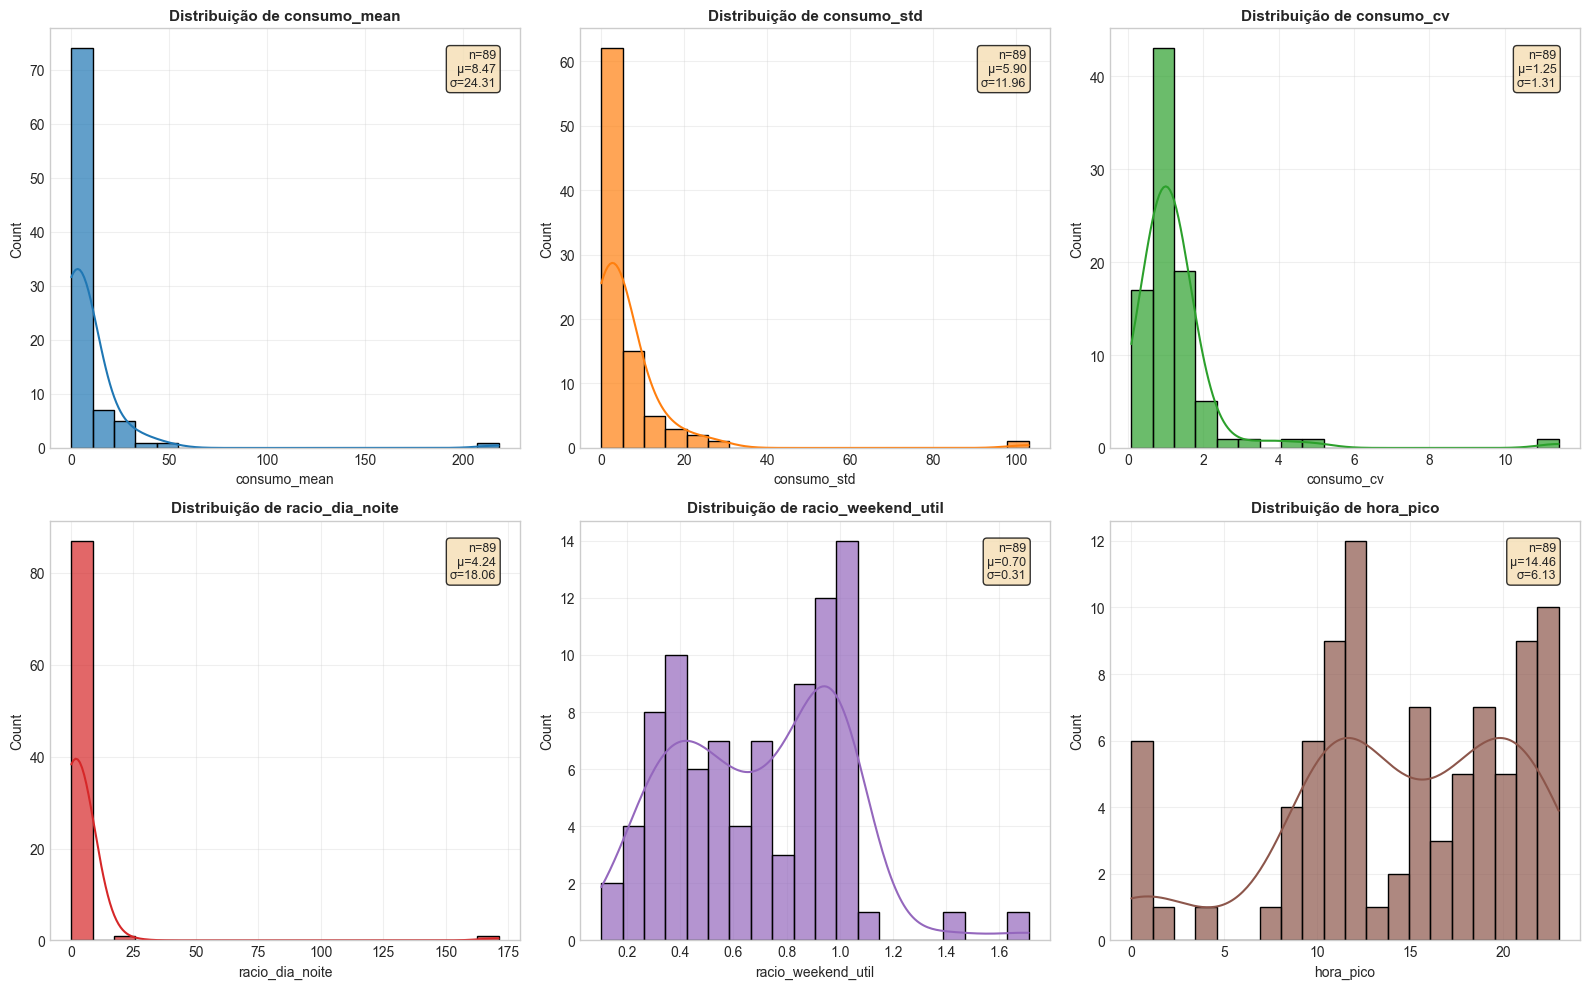


 MATRIZ DE CORRELAÇÃO:


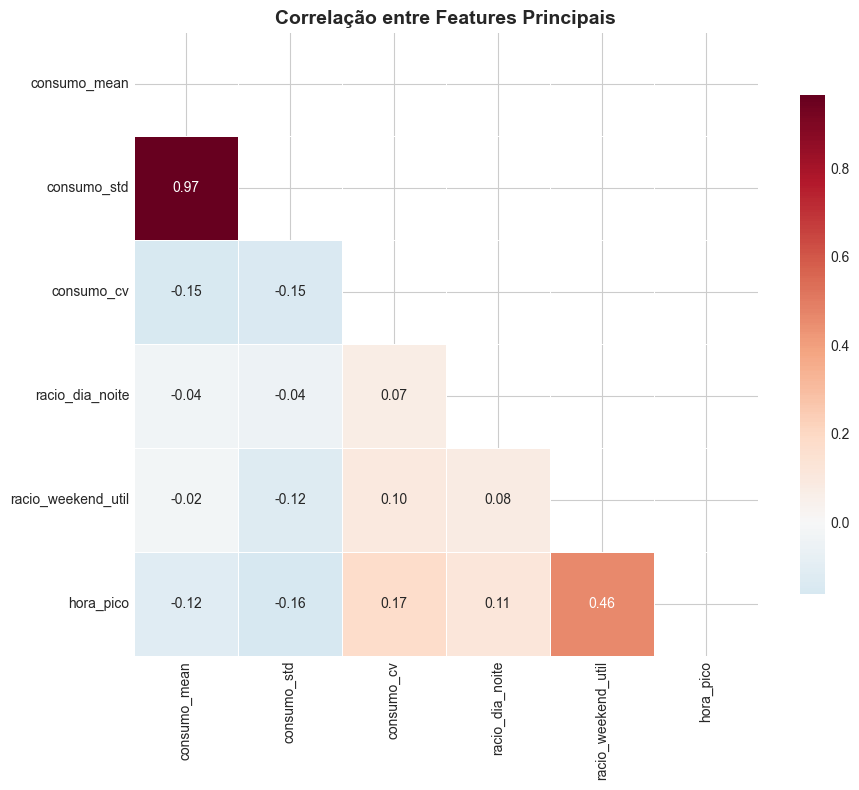

 CORRELAÇÕES ALTAS DETECTADAS (|ρ| > 0.8):
   consumo_mean ↔ consumo_std: 0.966

 ANÁLISE EXPLORATÓRIA CONCLUÍDA!
   Dados prontos para clustering: 89 CPEs × 60 features


In [71]:
print("Funções auxiliares para clustering carregadas!")

# ANÁLISE EXPLORATÓRIA INICIAL DOS DADOS

print(f"\n ANÁLISE EXPLORATÓRIA DOS DADOS:")

# Estatísticas descritivas das features
print(f"\nEstatísticas descritivas das {len(feature_cols)} features:")
stats_desc = df_features[feature_cols].describe().T
print(stats_desc.round(3))

# Verificar distribuição das features
print(f"\n DISTRIBUIÇÃO DAS FEATURES PRINCIPAIS:")
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

features_principais = ['consumo_mean', 'consumo_std', 'consumo_cv',
                      'racio_dia_noite', 'racio_weekend_util', 'hora_pico']

for i, feature in enumerate(features_principais):
    if feature in df_features.columns and i < len(axes):
        ax = axes[i]
        data = df_features[feature].dropna()

        if len(data) > 0:
            # Histograma com KDE
            sns.histplot(data, bins=20, kde=True, ax=ax, color=COLORS[i % len(COLORS)], alpha=0.7)

            # Estatísticas no gráfico
            stats_text = f'n={len(data)}\nμ={data.mean():.2f}\nσ={data.std():.2f}'
            ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
                   fontsize=9, va='top', ha='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        ax.set_title(f'Distribuição de {feature}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

# Remover axes vazios
for i in range(len(features_principais), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Matriz de correlação das features principais
print(f"\n MATRIZ DE CORRELAÇÃO:")
if len(features_principais) > 1:
    corr_matrix = df_features[features_principais].corr()

    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, ax=ax, mask=mask,
                cbar_kws={'shrink': 0.8})
    ax.set_title('Correlação entre Features Principais', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Identificar correlações altas
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = abs(corr_matrix.iloc[i, j])
            if corr_val > 0.8:
                high_corr.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })

    if high_corr:
        print(" CORRELAÇÕES ALTAS DETECTADAS (|ρ| > 0.8):")
        for corr in high_corr:
            print(f"   {corr['feature1']} ↔ {corr['feature2']}: {corr['correlation']:.3f}")
    else:
        print(" Nenhuma correlação alta detectada entre features principais.")

print(f"\n ANÁLISE EXPLORATÓRIA CONCLUÍDA!")
print(f"   Dados prontos para clustering: {len(df_features)} CPEs × {len(feature_cols)} features")

In [72]:
# Estatísticas descritivas
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
consumo_mean,89.0000,8.4710,24.3130,0.0000,0.6331,3.1153,6.0229,218.1930
consumo_std,89.0000,5.8974,11.9649,0.0000,0.6902,3.1738,5.7351,103.0954
consumo_min,89.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
consumo_max,89.0000,41.5542,83.4533,0.0000,5.0000,22.1760,37.0000,574.0000
consumo_median,89.0000,6.4765,21.9542,0.0000,0.1160,1.2160,3.0000,196.0000
...,...,...,...,...,...,...,...,...
consumo_noturno,89.0000,5.4449,13.6076,0.0000,0.4360,1.4888,4.2823,113.7147
racio_dia_noite,89.0000,4.2426,18.0577,0.2059,1.1226,1.7688,2.9298,171.1682
variabilidade_intra_dia_mean,89.0000,4.1552,9.8383,0.0000,0.4203,2.3226,3.9895,87.8911
variabilidade_inter_dia,89.0000,3.2319,5.8642,0.0000,0.4334,1.6088,3.3297,46.2885


## 2. Preparação dos Dados para Clustering

In [73]:
# PREPARAÇÃO AVANÇADA DOS DADOS PARA CLUSTERING

print("PREPARAÇÃO AVANÇADA DOS DADOS PARA CLUSTERING")

# Separar identificadores e features
cpe_ids = df_features['CPE'].values

# Selecionar apenas colunas numéricas para clustering (excluir CPE e n_registos)
cols_to_exclude = ['CPE', 'n_registos']
feature_cols = [col for col in df_features.columns if col not in cols_to_exclude]

# Verificar se há colunas não numéricas
numeric_cols = df_features[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Features selecionadas para clustering: {len(numeric_cols)}")
print(f"\nFeatures:")
for i, col in enumerate(numeric_cols, 1):
    print(f"  {i:2d}. {col}")

PREPARAÇÃO AVANÇADA DOS DADOS PARA CLUSTERING
Features selecionadas para clustering: 60

Features:
   1. consumo_mean
   2. consumo_std
   3. consumo_min
   4. consumo_max
   5. consumo_median
   6. consumo_q25
   7. consumo_q75
   8. consumo_cv
   9. consumo_iqr_norm
  10. consumo_noite
  11. consumo_manhã
  12. consumo_tarde
  13. consumo_h00
  14. consumo_h01
  15. consumo_h02
  16. consumo_h03
  17. consumo_h04
  18. consumo_h05
  19. consumo_h06
  20. consumo_h07
  21. consumo_h08
  22. consumo_h09
  23. consumo_h10
  24. consumo_h11
  25. consumo_h12
  26. consumo_h13
  27. consumo_h14
  28. consumo_h15
  29. consumo_h16
  30. consumo_h17
  31. consumo_h18
  32. consumo_h19
  33. consumo_h20
  34. consumo_h21
  35. consumo_h22
  36. consumo_h23
  37. consumo_seg
  38. consumo_ter
  39. consumo_qua
  40. consumo_qui
  41. consumo_sex
  42. consumo_sab
  43. consumo_dom
  44. consumo_dias_uteis
  45. consumo_fim_semana
  46. racio_weekend_util
  47. avg_afternoon_peak_value
  48. a

In [74]:
# VALIDAÇÃO ROBUSTA DA QUALIDADE DOS DADOS

print("\n VALIDAÇÃO ROBUSTA DA QUALIDADE DOS DADOS")

# 1. Verificar valores nulos
null_counts = df_features[numeric_cols].isnull().sum()
total_nulls = null_counts.sum()
if total_nulls > 0:
    print(f" Valores nulos encontrados: {total_nulls}")
    print(f"   Features com nulos: {sum(null_counts > 0)}")
    for col, count in null_counts[null_counts > 0].items():
        pct = count / len(df_features) * 100
        print(f"   • {col}: {count} nulos ({pct:.1f}%)")
    
    # Estratégia: Preencher com mediana (mais robusto que média)
    for col in numeric_cols:
        if df_features[col].isnull().sum() > 0:
            median_val = df_features[col].median()
            df_features[col] = df_features[col].fillna(median_val)
            print(f"   ✓ Preenchidos {df_features[col].isnull().sum()} nulos em '{col}' com mediana {median_val:.3f}")
else:
    print(" Valores nulos: Nenhum encontrado")

# 2. Verificar valores infinitos
inf_counts = np.isinf(df_features[numeric_cols]).sum()
total_inf = inf_counts.sum()
if total_inf > 0:
    print(f"\n Valores infinitos encontrados: {total_inf}")
    for col, count in inf_counts[inf_counts > 0].iteritems():
        pct = count / len(df_features) * 100
        print(f"   • {col}: {count} infinitos ({pct:.1f}%)")
else:
    print("\n Valores infinitos: Nenhum encontrado")

# 3. Verificar valores constantes (variância zero)
constant_cols = []
for col in numeric_cols:
    if df_features[col].var() == 0:
        constant_cols.append(col)

if constant_cols:
    print(f"\n Features com variância zero (constantes): {len(constant_cols)}")
    for col in constant_cols:
        print(f"   • {col}: valor constante = {df_features[col].iloc[0]}")
    # Remover features constantes
    numeric_cols = [col for col in numeric_cols if col not in constant_cols]
    print(f"   ✓ Removidas {len(constant_cols)} features constantes")
else:
    print("\n Features constantes: Nenhuma encontrada")

# 4. Verificar features com alta correlação (multicolinearidade)
# Remover features altamente correlacionadas automaticamente
if len(numeric_cols) > 1:
    corr_matrix = df_features[numeric_cols].corr().abs()
    high_corr_pairs = []
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            corr_val = corr_matrix.iloc[i, j]
            if corr_val > 0.95:  # Threshold alto para multicolinearidade
                high_corr_pairs.append({
                    'feature1': numeric_cols[i],
                    'feature2': numeric_cols[j],
                    'correlation': corr_val
                })
    
    if high_corr_pairs:
        print(f"\n Pares com correlação muito alta (|ρ| > 0.95): {len(high_corr_pairs)}")
        for pair in high_corr_pairs[:10]:  # Mostrar apenas primeiros 10
            print(f"   • {pair['feature1']} ↔ {pair['feature2']}: {pair['correlation']:.3f}")
        if len(high_corr_pairs) > 10:
            print(f"   ... e mais {len(high_corr_pairs) - 10} pares")
        
        # Remover features redundantes automaticamente
        print("\n Removendo features redundantes para reduzir multicolinearidade...")
        features_to_remove = set()
        
        # Estratégia: remover features que são altamente correlacionadas com consumo_mean
        # (consumo_mean é a feature mais importante, manter ela)
        if 'consumo_mean' in numeric_cols:
            for pair in high_corr_pairs:
                if pair['feature1'] == 'consumo_mean':
                    features_to_remove.add(pair['feature2'])
                elif pair['feature2'] == 'consumo_mean':
                    features_to_remove.add(pair['feature1'])
                else:
                    # Se nenhuma é consumo_mean, remover a segunda (menos importante)
                    features_to_remove.add(pair['feature2'])
        
        # Remover features redundantes
        numeric_cols_clean = [col for col in numeric_cols if col not in features_to_remove]
        print(f"   • Features removidas: {len(features_to_remove)}")
        print(f"   • Features mantidas: {len(numeric_cols_clean)}")
        if len(features_to_remove) > 0:
            print(f"   • Features removidas: {list(features_to_remove)[:10]}")
            if len(features_to_remove) > 10:
                print(f"     ... e mais {len(features_to_remove) - 10}")
        
        numeric_cols = numeric_cols_clean
    else:
        print("\n Multicolinearidade alta: Nenhuma detectada")

print(f"\n Resumo da validação:")
print(f"   • Features válidas para clustering: {len(numeric_cols)}")
print(f"   • CPEs totais: {len(df_features)}")


 VALIDAÇÃO ROBUSTA DA QUALIDADE DOS DADOS
 Valores nulos: Nenhum encontrado

 Valores infinitos: Nenhum encontrado

 Features com variância zero (constantes): 1
   • consumo_min: valor constante = 0.0
   ✓ Removidas 1 features constantes

 Pares com correlação muito alta (|ρ| > 0.95): 1007
   • consumo_mean ↔ consumo_std: 0.966
   • consumo_mean ↔ consumo_median: 0.995
   • consumo_mean ↔ consumo_q25: 0.983
   • consumo_mean ↔ consumo_q75: 0.998
   • consumo_mean ↔ consumo_noite: 0.994
   • consumo_mean ↔ consumo_manhã: 0.998
   • consumo_mean ↔ consumo_tarde: 0.997
   • consumo_mean ↔ consumo_h00: 0.970
   • consumo_mean ↔ consumo_h01: 0.958
   • consumo_mean ↔ consumo_h02: 0.957
   ... e mais 997 pares

 Removendo features redundantes para reduzir multicolinearidade...
   • Features removidas: 48
   • Features mantidas: 11
   • Features removidas: ['consumo_h11', 'consumo_h17', 'consumo_qua', 'valor_vale', 'consumo_h20', 'consumo_q75', 'consumo_sab', 'consumo_h06', 'amplitude_diaria


 DETECÇÃO DE OUTLIERS NAS FEATURES
Outliers detectados por feature (método IQR):
                       feature  n_outliers pct_outliers           range
                  consumo_mean          11        12.4%  [-7.45, 14.11]
                   consumo_max           9        10.1% [-43.00, 85.00]
                    consumo_cv           7         7.9%    [0.10, 2.01]
              consumo_iqr_norm           1         1.1%   [-0.68, 2.51]
            racio_weekend_util           0         0.0%   [-0.43, 1.82]
           avg_daily_peak_time           3         3.4%   [2.80, 20.67]
avg_time_below_50%_consumption           8         9.0%    [0.26, 1.07]
                     hora_pico           0         0.0%  [-2.50, 33.50]
                     hora_vale          18        20.2%  [-1.00, 15.00]
               racio_pico_vale          12        13.5%  [-3.30, 13.36]
               racio_dia_noite           4         4.5%   [-1.59, 5.64]

  Features com >10% outliers: 4
   • consumo_mean: 12

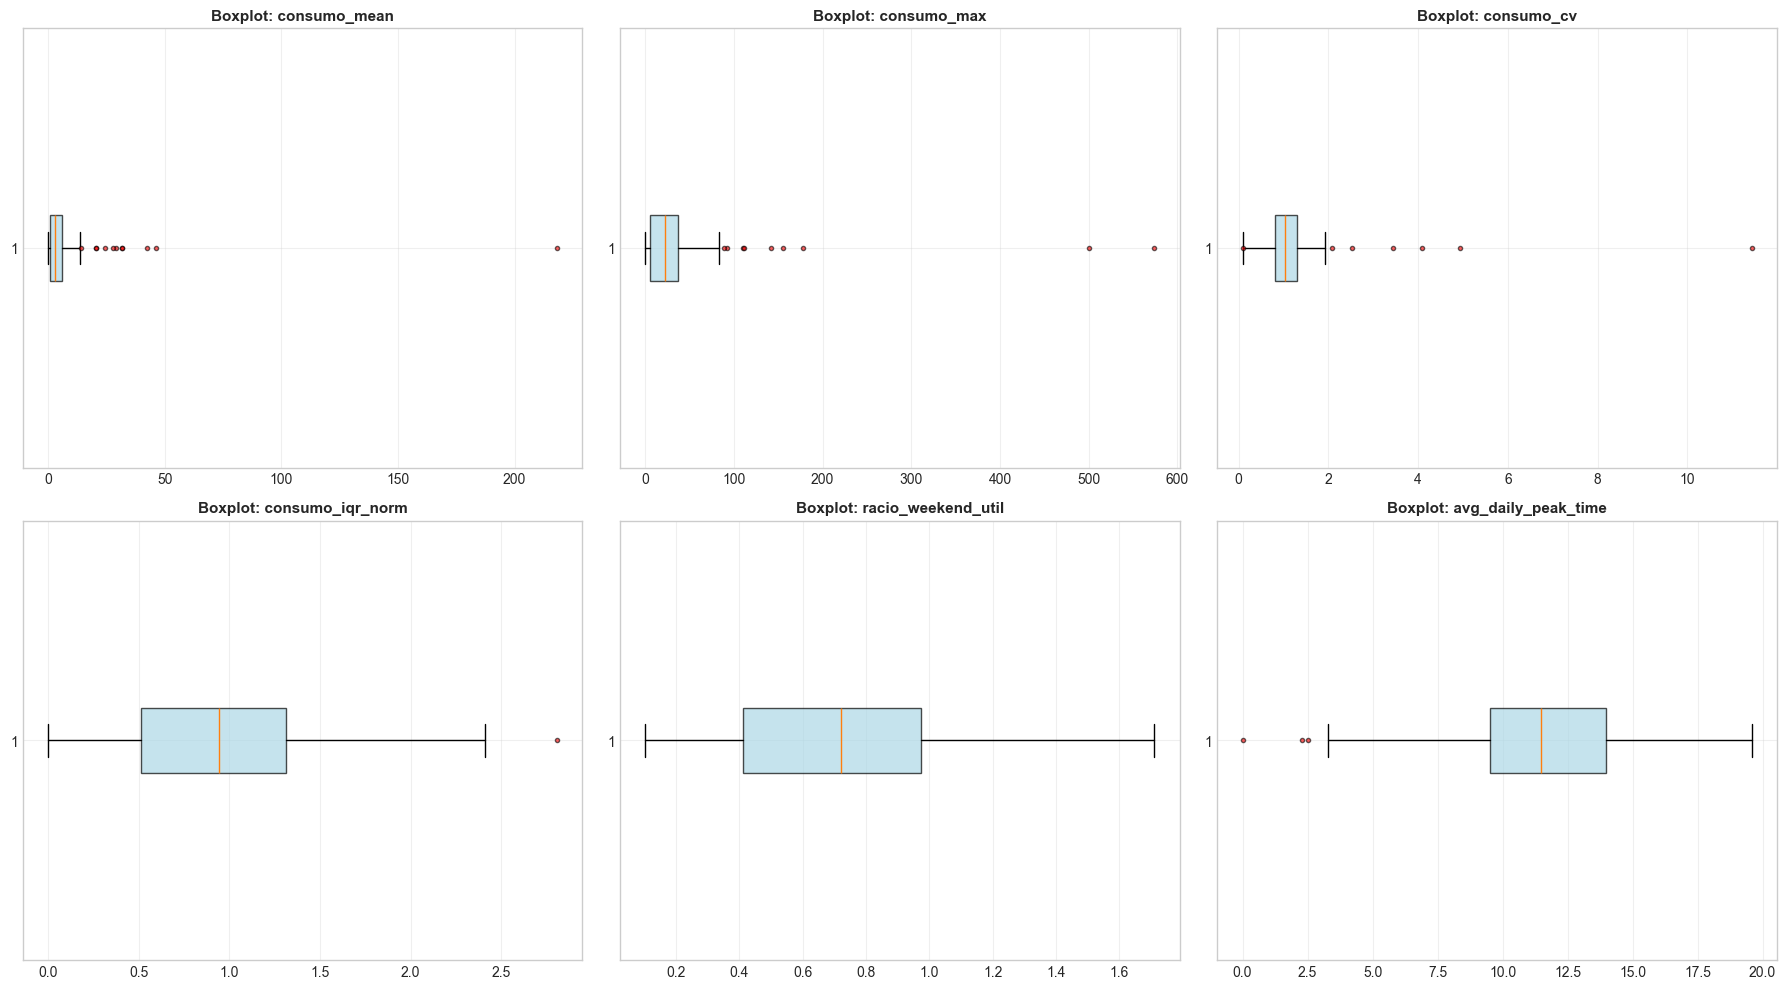

In [75]:
# DETECÇÃO DE OUTLIERS NAS FEATURES

print("\n DETECÇÃO DE OUTLIERS NAS FEATURES")

# Usar IQR method para detectar outliers
def detectar_outliers_iqr(data, multiplier=IQR_MULTIPLIER):
    """Detecta outliers usando o método IQR."""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_summary = []
for col in numeric_cols:
    outliers, lower, upper = detectar_outliers_iqr(df_features[col])
    pct_outliers = len(outliers) / len(df_features) * 100
    outlier_summary.append({
        'feature': col,
        'n_outliers': len(outliers),
        'pct_outliers': pct_outliers,
        'range': f'[{lower:.2f}, {upper:.2f}]'
    })

outlier_df = pd.DataFrame(outlier_summary)
print("Outliers detectados por feature (método IQR):")
print(outlier_df.to_string(index=False, formatters={'pct_outliers': '{:.1f}%'.format}))

# Identificar features com muitos outliers
high_outlier_features = outlier_df[outlier_df['pct_outliers'] > 10]['feature'].tolist()
if high_outlier_features:
    print(f"\n  Features com >10% outliers: {len(high_outlier_features)}")
    for feature in high_outlier_features:
        print(f"   • {feature}: {outlier_df[outlier_df['feature']==feature]['pct_outliers'].iloc[0]:.1f}% outliers")
    print("   Considerar transformação logarítmica ou robusta normalização")
else:
    print("\n Features com muitos outliers: Nenhuma encontrada")

# Visualizar distribuição de outliers para features principais
features_plot = numeric_cols[:6]  # Primeiras 6 features
if len(features_plot) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(features_plot):
        if i < len(axes):
            ax = axes[i]
            data = df_features[col].dropna()
            
            # Boxplot para visualizar outliers
            ax.boxplot(data, vert=False, patch_artist=True, 
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.6))
            
            ax.set_title(f'Boxplot: {col}', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
    
    # Remover axes vazios
    for i in range(len(features_plot), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

### 2.3 Remoção de Outliers Antes do Clustering

**MELHORAMENTO CRÍTICO**:
   Remover outliers antes das análises dos algoritmos para análises mais precisas,
conforme requisito do utilizador.

In [76]:
# REMOÇÃO DE OUTLIERS ANTES DO CLUSTERING
# Remover outliers para análises mais precisas, conforme requisito do utilizador

print("REMOÇÃO DE OUTLIERS ANTES DO CLUSTERING")

def remover_outliers_iqr_multivariate(df, feature_cols, multiplier=2.0):
    """
    Remove outliers usando método IQR multivariado.
    Um CPE é considerado outlier se for outlier em múltiplas features.
    """
    outlier_mask = pd.Series([False] * len(df), index=df.index)
    outlier_counts = pd.Series([0] * len(df), index=df.index)
    
    for col in feature_cols:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            if IQR > 0:  # Evitar divisão por zero
                lower_bound = Q1 - multiplier * IQR
                upper_bound = Q3 + multiplier * IQR
                col_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
                outlier_mask = outlier_mask | col_outliers
                outlier_counts += col_outliers.astype(int)
    
    # Considerar outlier se for outlier em pelo menos 2 features (ou 10% das features)
    min_outlier_features = max(2, int(len(feature_cols) * 0.1))
    final_outlier_mask = outlier_counts >= min_outlier_features
    
    return final_outlier_mask, outlier_counts

# Detectar outliers
print(f"\nDetectando outliers em {len(numeric_cols)} features (método IQR multivariado)...")
outlier_mask, outlier_counts = remover_outliers_iqr_multivariate(df_features, numeric_cols, multiplier=2.0)

n_outliers = outlier_mask.sum()
pct_outliers = n_outliers / len(df_features) * 100

print(f"Outliers detectados: {n_outliers} CPEs ({pct_outliers:.1f}%)")
print(f"Critério: CPEs que são outliers em pelo menos {max(2, int(len(numeric_cols) * 0.1))} features")

if n_outliers > 0:
    print(f"\nCPEs identificados como outliers:")
    outliers_cpes = df_features[outlier_mask]['CPE'].tolist()
    for i, cpe in enumerate(outliers_cpes[:10], 1):
        cpe_idx = df_features[df_features['CPE'] == cpe].index[0]
        n_outlier_features = outlier_counts.loc[cpe_idx]
        print(f"  {i}. {cpe} (outlier em {n_outlier_features} features)")
    if len(outliers_cpes) > 10:
        print(f"  ... e mais {len(outliers_cpes) - 10} CPEs")
    
    # Remover outliers
    df_features_clean = df_features[~outlier_mask].copy()
    
    print(f"\n✓ Outliers removidos:")
    print(f"  - Antes: {len(df_features)} CPEs")
    print(f"  - Depois: {len(df_features_clean)} CPEs")
    print(f"  - Removidos: {n_outliers} CPEs ({pct_outliers:.1f}%)")
    
    # Guardar lista de outliers removidos para referência
    outliers_removed = df_features[outlier_mask]['CPE'].tolist()
    
    # Substituir df_features
    df_features = df_features_clean
    print(f"\n Dataset limpo: {len(df_features)} CPEs prontos para clustering")
    
    # Guardar outliers removidos para análise posterior
    import json
    outliers_file = 'data/intermediate/outliers_removed_clustering.json'
    os.makedirs(os.path.dirname(outliers_file), exist_ok=True)
    with open(outliers_file, 'w') as f:
        json.dump(outliers_removed, f, indent=2)
    print(f"  • Lista de outliers guardada em: {outliers_file}")
else:
    print("\n Nenhum outlier extremo detectado. Todos os CPEs mantidos.")
    outliers_removed = []


REMOÇÃO DE OUTLIERS ANTES DO CLUSTERING

Detectando outliers em 11 features (método IQR multivariado)...
Outliers detectados: 15 CPEs (16.9%)
Critério: CPEs que são outliers em pelo menos 2 features

CPEs identificados como outliers:
  1. PT0002000032959511HP (outlier em 2 features)
  2. PT0002000065256275YB (outlier em 3 features)
  3. PT0002000068856781NM (outlier em 2 features)
  4. PT0002000068859325FL (outlier em 2 features)
  5. PT0002000068859393XH (outlier em 2 features)
  6. PT0002000068859597LS (outlier em 2 features)
  7. PT0002000073598156DE (outlier em 3 features)
  8. PT0002000073717386HC (outlier em 3 features)
  9. PT0002000078441876HB (outlier em 2 features)
  10. PT0002000081997398TD (outlier em 2 features)
  ... e mais 5 CPEs

✓ Outliers removidos:
  - Antes: 89 CPEs
  - Depois: 74 CPEs
  - Removidos: 15 CPEs (16.9%)

 Dataset limpo: 74 CPEs prontos para clustering
  • Lista de outliers guardada em: data/intermediate/outliers_removed_clustering.json


In [77]:
# CRIAÇÃO DA MATRIZ DE FEATURES

print("\n CRIAÇÃO DA MATRIZ DE FEATURES")

# Criar matriz de features
X = df_features[numeric_cols].values

print(f"Matriz de features criada:")
print(f"  • Dimensões: {X.shape}")
print(f"  • {X.shape[0]} CPEs (linhas)")
print(f"  • {X.shape[1]} features (colunas)")

# Estatísticas finais da matriz
print(f"\n Estatísticas da matriz de features:")
feature_stats = df_features[numeric_cols].describe().T[['count', 'mean', 'std', 'min', 'max']]
print(feature_stats.round(3))

# Verificar se há valores problemáticos finais
final_nulls = np.isnan(X).sum()
final_infs = np.isinf(X).sum()

print(f"\n Verificação final:")
print(f"  • Valores NaN: {final_nulls}")
print(f"  • Valores infinitos: {final_infs}")

if final_nulls > 0 or final_infs > 0:
    print("   Ainda há valores problemáticos. A corrigir...")
    X = np.nan_to_num(X, nan=0, posinf=0, neginf=0)
    print("  ✓ Valores problemáticos corrigidos")
else:
    print("   Matriz pronta para clustering!")

print(f"\n PREPARAÇÃO DOS DADOS CONCLUÍDA!")
print(f"   Matriz final: {X.shape[0]} × {X.shape[1]} (CPEs × Features)")


 CRIAÇÃO DA MATRIZ DE FEATURES
Matriz de features criada:
  • Dimensões: (74, 11)
  • 74 CPEs (linhas)
  • 11 features (colunas)

 Estatísticas da matriz de features:
                                 count    mean      std    min       max
consumo_mean                   74.0000  3.8410   4.3440 0.0080   20.4870
consumo_max                    74.0000 23.5560  22.3030 0.0680   92.0000
consumo_cv                     74.0000  1.1510   0.6160 0.1040    4.0790
consumo_iqr_norm               74.0000  1.0010   0.6050 0.0000    2.8070
racio_weekend_util             74.0000  0.6700   0.3160 0.1030    1.7100
avg_daily_peak_time            74.0000 11.5390   3.3370 2.2710   18.5400
avg_time_below_50%_consumption 74.0000  0.6460   0.1890 0.0040    0.8920
hora_pico                      74.0000 14.8650   5.9730 0.0000   23.0000
hora_vale                      74.0000  8.5950   6.4190 0.0000   23.0000
racio_pico_vale                74.0000 48.2660 269.9440 1.0360 2062.7610
racio_dia_noite              

### 2.1 Normalização dos Dados

Vamos criar versões normalizadas dos dados para comparar o impacto da normalização no
clustering.

In [78]:
# Normalização com StandardScaler (média=0, std=1)
scaler_standard = StandardScaler()
X_standard = scaler_standard.fit_transform(X)

# Normalização com MinMaxScaler (valores entre 0 e 1)
scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X)

print("Dados normalizados:")
print(f"\nOriginal:")
print(f"  - Média: {X.mean():.2f}, Std: {X.std():.2f}")
print(f"  - Min: {X.min():.2f}, Max: {X.max():.2f}")

print(f"\nStandardScaler:")
print(f"  - Média: {X_standard.mean():.4f}, Std: {X_standard.std():.4f}")
print(f"  - Min: {X_standard.min():.2f}, Max: {X_standard.max():.2f}")

print(f"\nMinMaxScaler:")
print(f"  - Média: {X_minmax.mean():.4f}, Std: {X_minmax.std():.4f}")
print(f"  - Min: {X_minmax.min():.2f}, Max: {X_minmax.max():.2f}")

Dados normalizados:

Original:
  - Média: 10.56, Std: 82.35
  - Min: 0.00, Max: 2062.76

StandardScaler:
  - Média: 0.0000, Std: 1.0000
  - Min: -3.42, Max: 7.51

MinMaxScaler:
  - Média: 0.3677, Std: 0.2904
  - Min: 0.00, Max: 1.00


---

## 3. K-Means Clustering

### 3.1 K-Means SEM Normalização

In [79]:
# Testar K-Means para mais valores de k
k_range = K_RANGE_ATUAL if 'K_RANGE_ATUAL' in globals() else range(2, 16)

inertias_raw = []
silhouettes_raw = []
calinski_raw = []
davies_raw = []

print("K-Means SEM normalização:")
print(f"{'k':^5} | {'Inércia':^15} | {'Silhouette':^12} | {'Calinski-H':^12} | {'Davies-B':^12}")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=N_INIT_KMEANS, max_iter=MAX_ITER_KMEANS)
    labels = kmeans.fit_predict(X)

    inertia = kmeans.inertia_
    unique, counts = np.unique(labels, return_counts=True)
    min_size = counts.min() if len(counts) > 0 else 0
    
    if len(unique) < 2 or min_size < MIN_CLUSTER_SIZE:
        silhouette = np.nan
        calinski = np.nan
        davies = np.nan
    else:
        silhouette = silhouette_score(X, labels)
        try:
            calinski = calinski_harabasz_score(X, labels)
            davies = davies_bouldin_score(X, labels)
        except:
            calinski = np.nan
            davies = np.nan

    inertias_raw.append(inertia)
    silhouettes_raw.append(silhouette)
    calinski_raw.append(calinski)
    davies_raw.append(davies)
    
    sil_str = f"{silhouette:.4f}" if not np.isnan(silhouette) else "N/A"
    cal_str = f"{calinski:.1f}" if not np.isnan(calinski) else "N/A"
    dav_str = f"{davies:.3f}" if not np.isnan(davies) else "N/A"
    
    print(f"{k:^5} | {inertia:>13,.0f} | {sil_str:^12} | {cal_str:^12} | {dav_str:^12}")

print("\nConcluído!")

K-Means SEM normalização:
  k   |     Inércia     |  Silhouette  |  Calinski-H  |   Davies-B  
  2   |       497,706 |    0.9638    |    703.9     |    0.315    
  3   |        44,145 |    0.9469    |    4277.9    |    0.016    
  4   |        19,393 |    0.5392    |    6430.4    |    0.330    
  5   |        10,601 |    0.4279    |    8720.7    |    0.479    
  6   |         8,565 |    0.4068    |    8503.6    |    0.608    
  7   |         6,882 |    0.4109    |    8692.4    |    0.601    
  8   |         5,981 |    0.3430    |    8446.5    |    0.712    
  9   |         5,387 |    0.3183    |    8081.3    |    0.826    

Concluído!


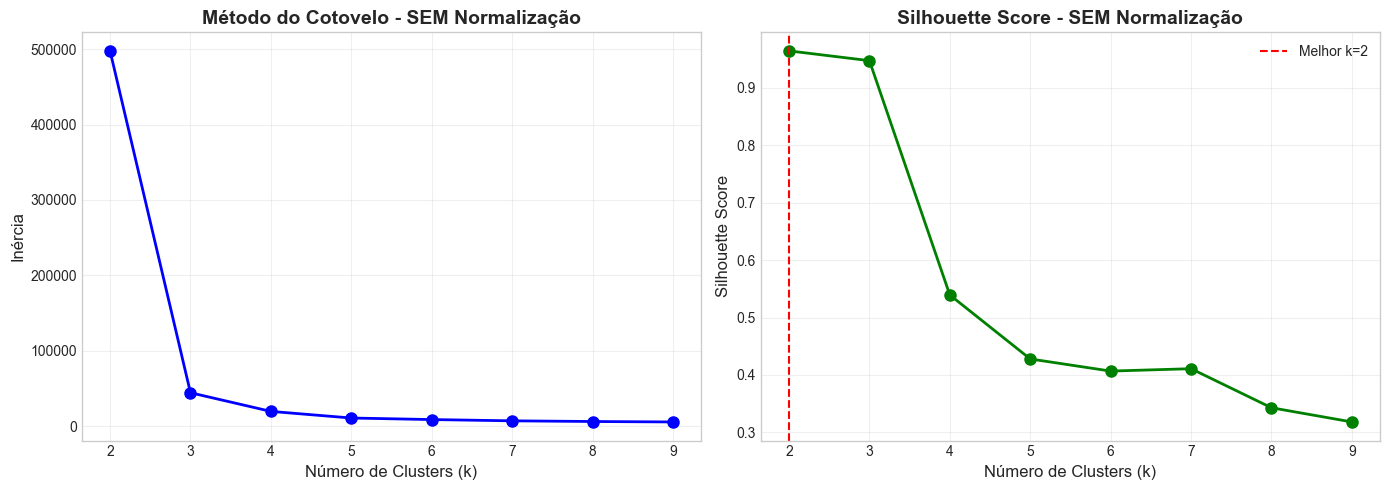


Melhor k (maior silhouette) SEM normalização: 2
Silhouette score: 0.9638


In [80]:
# Visualizar resultados (sem normalização)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico do Cotovelo (Elbow)
ax1 = axes[0]
ax1.plot(list(k_range), inertias_raw, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (k)', fontsize=12)
ax1.set_ylabel('Inércia', fontsize=12)
ax1.set_title('Método do Cotovelo - SEM Normalização', fontsize=14, fontweight='bold')
ax1.set_xticks(list(k_range))
ax1.grid(True, alpha=0.3)

# Gráfico do Silhouette
ax2 = axes[1]
ax2.plot(list(k_range), silhouettes_raw, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score - SEM Normalização', fontsize=14, fontweight='bold')
ax2.set_xticks(list(k_range))
ax2.grid(True, alpha=0.3)

# Marcar o melhor k apenas quando há silhouettes válidos
valid_raw = [(k, s) for k, s in zip(k_range, silhouettes_raw) if not np.isnan(s)]
if valid_raw:
    best_k_raw, best_silhouette_raw = max(valid_raw, key=lambda x: x[1])
    ax2.axvline(best_k_raw, color='red', linestyle='--', label=f'Melhor k={best_k_raw}')
else:
    best_k_raw, best_silhouette_raw = None, np.nan

ax2.legend()

plt.tight_layout()
plt.show()

if best_k_raw is not None:
    print(f"\nMelhor k (maior silhouette) SEM normalização: {best_k_raw}")
    print(f"Silhouette score: {best_silhouette_raw:.4f}")
else:
    print("\nMelhor k (maior silhouette) SEM normalização: não definido (silhouettes inválidos)")

### 3.2 K-Means COM Normalização (StandardScaler)

In [81]:
# Testar K-Means com normalização para mais valores de k
inertias_standard = []
silhouettes_standard = []
calinski_standard = []
davies_standard = []

print("K-Means COM normalização (StandardScaler):")
print(f"{'k':^5} | {'Inércia':^15} | {'Silhouette':^12} | {'Calinski-H':^12} | {'Davies-B':^12}")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=N_INIT_KMEANS, max_iter=MAX_ITER_KMEANS)
    labels = kmeans.fit_predict(X_standard)

    inertia = kmeans.inertia_
    unique, counts = np.unique(labels, return_counts=True)
    min_size = counts.min() if len(counts) > 0 else 0
    
    if len(unique) < 2 or min_size < MIN_CLUSTER_SIZE:
        silhouette = np.nan
        calinski = np.nan
        davies = np.nan
    else:
        silhouette = silhouette_score(X_standard, labels)
        try:
            calinski = calinski_harabasz_score(X_standard, labels)
            davies = davies_bouldin_score(X_standard, labels)
        except:
            calinski = np.nan
            davies = np.nan

    inertias_standard.append(inertia)
    silhouettes_standard.append(silhouette)
    calinski_standard.append(calinski)
    davies_standard.append(davies)
    
    sil_str = f"{silhouette:.4f}" if not np.isnan(silhouette) else "N/A"
    cal_str = f"{calinski:.1f}" if not np.isnan(calinski) else "N/A"
    dav_str = f"{davies:.3f}" if not np.isnan(davies) else "N/A"
    
    print(f"{k:^5} | {inertia:>13,.2f} | {sil_str:^12} | {cal_str:^12} | {dav_str:^12}")

print("\nConcluído!")

K-Means COM normalização (StandardScaler):
  k   |     Inércia     |  Silhouette  |  Calinski-H  |   Davies-B  
  2   |        661.07 |    0.1846    |     16.7     |    1.900    
  3   |        562.48 |    0.1815    |     15.9     |    1.634    
  4   |        492.74 |    0.2142    |     15.2     |    1.447    
  5   |        420.23 |    0.2150    |     16.2     |    1.228    
  6   |        371.04 |    0.2394    |     16.2     |    1.071    
  7   |        310.19 |    0.2631    |     18.1     |    1.088    
  8   |        270.14 |    0.2632    |     19.0     |    1.051    
  9   |        248.28 |    0.2705    |     18.5     |    1.031    

Concluído!


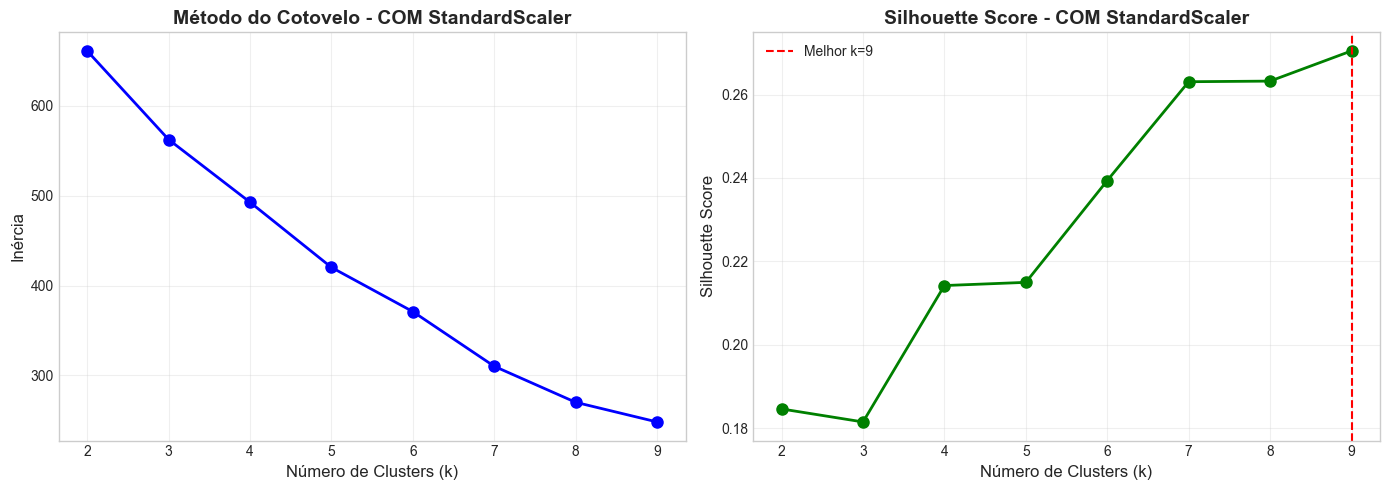


Melhor k (maior silhouette) COM StandardScaler: 9
Silhouette score: 0.2705


In [82]:
# Visualizar resultados (com StandardScaler)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico do Cotovelo (Elbow)
ax1 = axes[0]
ax1.plot(list(k_range), inertias_standard, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (k)', fontsize=12)
ax1.set_ylabel('Inércia', fontsize=12)
ax1.set_title('Método do Cotovelo - COM StandardScaler', fontsize=14, fontweight='bold')
ax1.set_xticks(list(k_range))
ax1.grid(True, alpha=0.3)

# Gráfico do Silhouette
ax2 = axes[1]
ax2.plot(list(k_range), silhouettes_standard, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score - COM StandardScaler', fontsize=14, fontweight='bold')
ax2.set_xticks(list(k_range))
ax2.grid(True, alpha=0.3)

# Marcar o melhor k apenas quando há silhouettes válidos
valid_standard = [(k, s) for k, s in zip(k_range, silhouettes_standard) if not np.isnan(s)]
if valid_standard:
    best_k_standard, best_silhouette_standard = max(valid_standard, key=lambda x: x[1])
    ax2.axvline(best_k_standard, color='red', linestyle='--', label=f'Melhor k={best_k_standard}')
else:
    best_k_standard, best_silhouette_standard = None, np.nan

ax2.legend()

plt.tight_layout()
plt.show()

if best_k_standard is not None:
    print(f"\nMelhor k (maior silhouette) COM StandardScaler: {best_k_standard}")
    print(f"Silhouette score: {best_silhouette_standard:.4f}")
else:
    print("\nMelhor k (maior silhouette) COM StandardScaler: não definido (silhouettes inválidos)")

### 3.3 Comparação: Com vs Sem Normalização

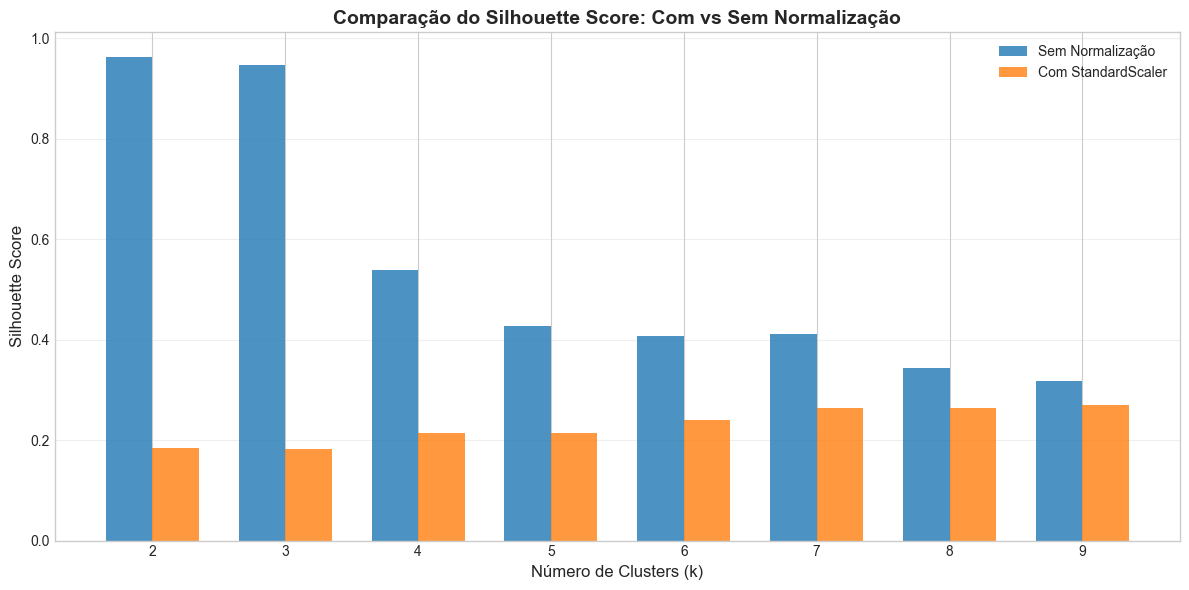


Tabela Comparativa:
  k   |  Sem Normalização  | Com StandardScaler
  2   |       0.9638       |       0.1846      
  3   |       0.9469       |       0.1815      
  4   |       0.5392       |       0.2142      
  5   |       0.4279       |       0.2150      
  6   |       0.4068       |       0.2394      
  7   |       0.4109       |       0.2631      
  8   |       0.3430       |       0.2632      
  9   |       0.3183       |       0.2705      


In [83]:
# Comparar silhouette scores
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(k_range))
width = 0.35

bars1 = ax.bar(x - width/2, silhouettes_raw, width, label='Sem Normalização', color=COLORS[0], alpha=0.8)
bars2 = ax.bar(x + width/2, silhouettes_standard, width, label='Com StandardScaler', color=COLORS[1], alpha=0.8)

ax.set_xlabel('Número de Clusters (k)', fontsize=12)
ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('Comparação do Silhouette Score: Com vs Sem Normalização', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(list(k_range))
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Tabela comparativa
print("\nTabela Comparativa:")
print(f"{'k':^5} | {'Sem Normalização':^18} | {'Com StandardScaler':^18}")
for i, k in enumerate(k_range):
    print(f"{k:^5} | {silhouettes_raw[i]:^18.4f} | {silhouettes_standard[i]:^18.4f}")

### 3.4 Modelo K-Means Final (com k escolhido)

In [84]:
# ESCOLHA DO NÚMERO ÓTIMO DE CLUSTERS (K)

import math

# Usar múltiplas métricas para escolher o melhor k
def escolher_melhor_k(silhouettes, calinski, davies, k_range):
    """
    Escolhe o melhor k usando múltiplas métricas.
    Prioriza silhouette, mas considera também Calinski-Harabasz e Davies-Bouldin.
    """
    valid_k = []
    for i, k in enumerate(k_range):
        sil = silhouettes[i]
        cal = calinski[i] if i < len(calinski) else np.nan
        dav = davies[i] if i < len(davies) else np.nan
        
        if not np.isnan(sil):
            # Score combinado: silhouette (peso 0.5), calinski normalizado (0.3), davies invertido (0.2)
            cal_norm = (cal - np.nanmin(calinski)) / (np.nanmax(calinski) - np.nanmin(calinski) + 1e-10) if not np.isnan(cal) else 0
            dav_norm = 1 - (dav - np.nanmin(davies)) / (np.nanmax(davies) - np.nanmin(davies) + 1e-10) if not np.isnan(dav) else 0
            score = 0.5 * sil + 0.3 * cal_norm + 0.2 * dav_norm
            valid_k.append((k, sil, cal, dav, score))
    
    if len(valid_k) == 0:
        return None, None, None, None, None
    
    # Ordenar por score combinado
    valid_k.sort(key=lambda x: x[4], reverse=True)
    best = valid_k[0]
    return best[0], best[1], best[2], best[3], best[4]

# Escolher melhor k com dados normalizados (preferido)
best_k_standard, best_sil_std, best_cal_std, best_dav_std, best_score_std = escolher_melhor_k(
    silhouettes_standard, calinski_standard, davies_standard, k_range
)

# Escolher melhor k sem normalização (fallback)
best_k_raw, best_sil_raw, best_cal_raw, best_dav_raw, best_score_raw = escolher_melhor_k(
    silhouettes_raw, calinski_raw, davies_raw, k_range
)

# Decidir qual usar
sil_raw_str = f"{best_sil_raw:.4f}" if best_sil_raw is not None else "NA"
sil_std_str = f"{best_sil_std:.4f}" if best_sil_std is not None else "NA"

# Fallback explícito para evitar erro quando não há silhouettes válidos
fallback_k = list(k_range)[len(k_range)//2]  # Usar k médio como fallback
k_fallback_used = False

if best_k_standard is not None:
    BEST_K = best_k_standard
    criterio = f"Máximo score combinado com dados normalizados (silhouette={best_sil_std:.4f}, score={best_score_std:.4f})"
elif best_k_raw is not None:
    BEST_K = best_k_raw
    criterio = f"Sem silhouette válido com normalização; usando valor sem normalização (silhouette={best_sil_raw:.4f})"
else:
    BEST_K = fallback_k
    criterio = f"Sem silhouettes válidos; fallback para k={BEST_K}"
    k_fallback_used = True

print(f" SELEÇÃO DO NÚMERO ÓTIMO DE CLUSTERS")

print(f" K escolhido para o modelo final: {BEST_K}")
if k_fallback_used:
    print("   • Aviso: k escolhido por fallback (silhouettes inválidos)")

print(f" JUSTIFICATIVA DA DECISÃO:")
print(f"   • Critério: {criterio}")
print(f"   • Silhouette score com StandardScaler: {sil_std_str}")
print(f"   • Silhouette score SEM normalização: {sil_raw_str}")

print(f" PORQUÊ USAR NORMALIZAÇÃO:")
print(f"   • Features têm escalas muito diferentes")
print(f"   • Exemplo: consumo_mean std = {X[:, 0].std():.2f}, consumo_std std = {X[:, 1].std():.2f}")
print(f"   • O K-Means é sensível à escala das variáveis")
print(f"   • Normalização garante que todas as features contribuem igualmente")

print(f" DECISÃO: Usar K-Means com k={BEST_K} clusters e dados normalizados (StandardScaler)")


 SELEÇÃO DO NÚMERO ÓTIMO DE CLUSTERS
 K escolhido para o modelo final: 8
 JUSTIFICATIVA DA DECISÃO:
   • Critério: Máximo score combinado com dados normalizados (silhouette=0.2632, score=0.6271)
   • Silhouette score com StandardScaler: 0.2632
   • Silhouette score SEM normalização: 0.9469
 PORQUÊ USAR NORMALIZAÇÃO:
   • Features têm escalas muito diferentes
   • Exemplo: consumo_mean std = 4.31, consumo_std std = 22.15
   • O K-Means é sensível à escala das variáveis
   • Normalização garante que todas as features contribuem igualmente
 DECISÃO: Usar K-Means com k=8 clusters e dados normalizados (StandardScaler)


In [85]:
# Treinar modelo final
if 'k_fallback_used' in globals() and k_fallback_used:
    print("[AVISO] k definido por fallback (sem silhouettes válidos)")

kmeans_final = KMeans(n_clusters=BEST_K, random_state=RANDOM_STATE, n_init=10, max_iter=300)
labels_kmeans = kmeans_final.fit_predict(X_standard)

# Adicionar labels ao DataFrame
df_features['cluster_kmeans'] = labels_kmeans

# Contar CPEs por cluster
print(f"Distribuição dos CPEs por cluster (K-Means, k={BEST_K}):")
cluster_counts = df_features['cluster_kmeans'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = count / len(df_features) * 100
    print(f"  Cluster {cluster}: {count} CPEs ({pct:.1f}%)")


Distribuição dos CPEs por cluster (K-Means, k=8):
  Cluster 0: 1 CPEs (1.4%)
  Cluster 1: 6 CPEs (8.1%)
  Cluster 2: 6 CPEs (8.1%)
  Cluster 3: 9 CPEs (12.2%)
  Cluster 4: 15 CPEs (20.3%)
  Cluster 5: 12 CPEs (16.2%)
  Cluster 6: 18 CPEs (24.3%)
  Cluster 7: 7 CPEs (9.5%)


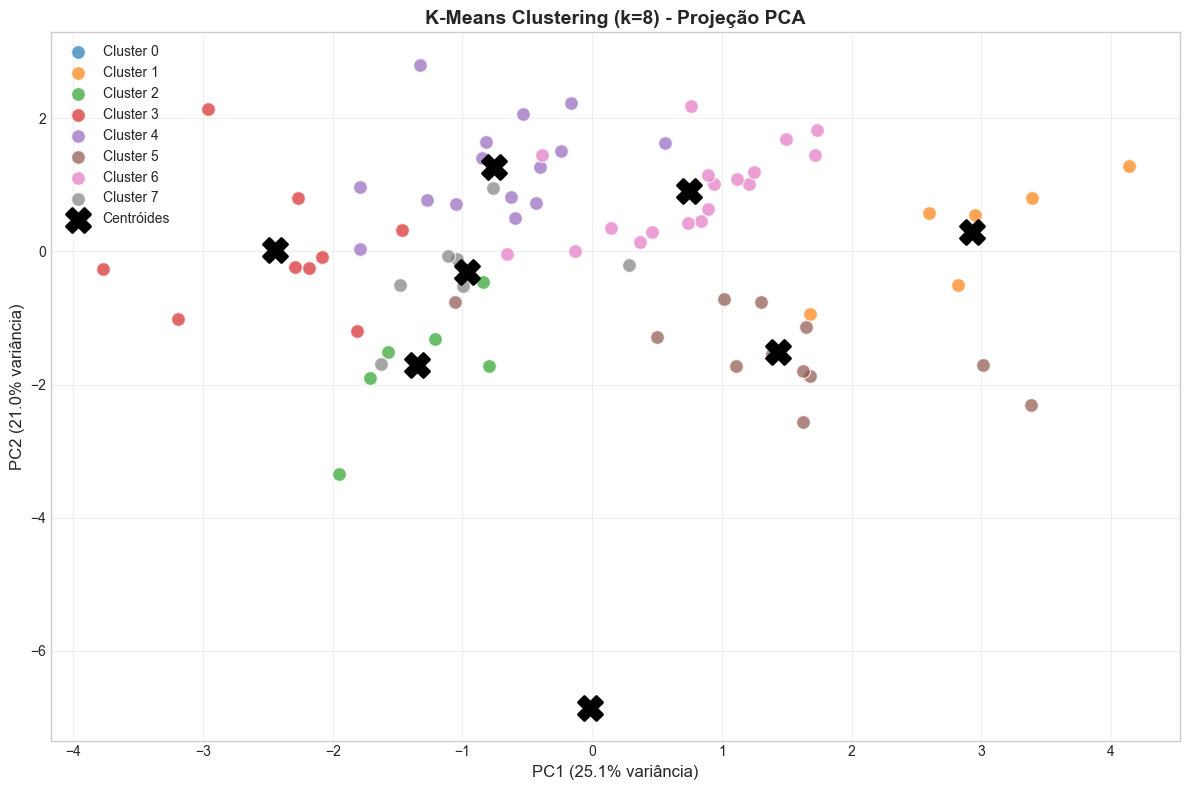


Variância explicada pelo PCA: 46.1%


In [86]:
# Visualização com PCA (redução para 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standard)

fig, ax = plt.subplots(figsize=(12, 8))

for cluster in range(BEST_K):
    mask = labels_kmeans == cluster
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=COLORS[cluster % len(COLORS)], 
               label=f'Cluster {cluster}', 
               alpha=0.7, s=100, edgecolors='white')

# Marcar centróides
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
           c='black', marker='X', s=300, linewidths=2, 
           label='Centróides')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variância)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variância)', fontsize=12)
ax.set_title(f'K-Means Clustering (k={BEST_K}) - Projeção PCA', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVariância explicada pelo PCA: {sum(pca.explained_variance_ratio_)*100:.1f}%")

K-DISTANCE PLOT PARA ESCOLHA DE EPS NO DBSCAN

Este gráfico ajuda a escolher o valor de eps de forma rigorosa.
O 'cotovelo' na curva indica um bom valor de eps.

 Análise do K-Distance Plot:
   • Distância mínima: 1.2848
   • Distância máxima: 8.7960
   • Distância mediana: 2.1109
   • eps sugerido (cotovelo): 8.7960

 Interpretação:
   • Valores de eps muito baixos (< 4.398) resultam em muitos clusters pequenos
   • Valores de eps muito altos (> 17.592) resultam em poucos clusters grandes
   • eps ≈ 8.796 é um bom ponto de partida para experimentação


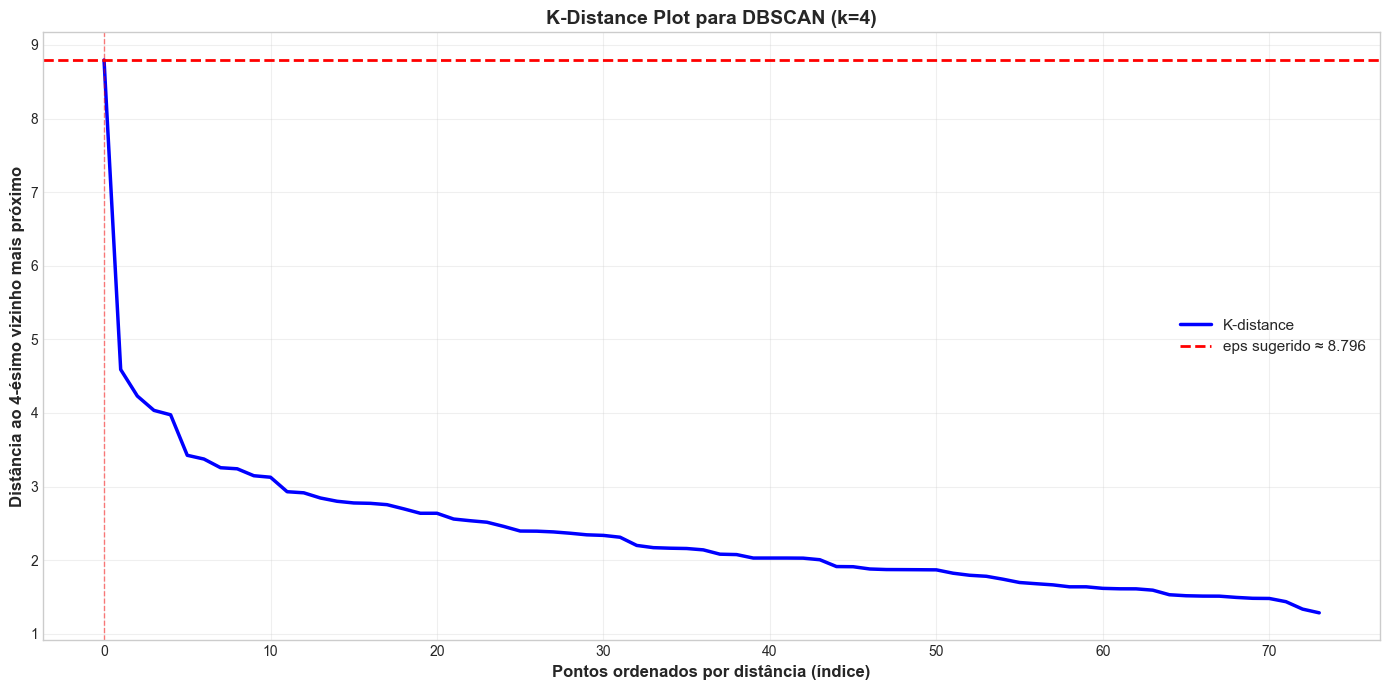


 K-distance plot gerado com sucesso!
   eps sugerido: 8.7960
   Este valor será considerado na experimentação de parâmetros abaixo.



In [87]:
# K-DISTANCE PLOT PARA ESCOLHA RIGOROSA DE EPS
# O k-distance plot é essencial para escolher eps de forma rigorosa no DBSCAN
# Mostra a distância ao k-ésimo vizinho mais próximo para cada ponto

from sklearn.neighbors import NearestNeighbors

print("K-DISTANCE PLOT PARA ESCOLHA DE EPS NO DBSCAN")
print("\nEste gráfico ajuda a escolher o valor de eps de forma rigorosa.")
print("O 'cotovelo' na curva indica um bom valor de eps.\n")

# Usar min_samples sugerido (geralmente 4 para começar)
k_for_plot = 4  # min_samples - 1

# Calcular distâncias aos k vizinhos mais próximos
nbrs = NearestNeighbors(n_neighbors=k_for_plot + 1).fit(X_standard)
distances, indices = nbrs.kneighbors(X_standard)

# Distância ao k-ésimo vizinho mais próximo (excluir o próprio ponto)
k_distances = distances[:, k_for_plot]
k_distances_sorted = np.sort(k_distances)[::-1]

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(range(len(k_distances_sorted)), k_distances_sorted, 'b-', linewidth=2.5, label='K-distance')
ax.set_xlabel('Pontos ordenados por distância (índice)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'Distância ao {k_for_plot}-ésimo vizinho mais próximo', fontsize=12, fontweight='bold')
ax.set_title(f'K-Distance Plot para DBSCAN (k={k_for_plot})', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Encontrar "cotovelo" sugerido (ponto de maior mudança na segunda derivada)
if len(k_distances_sorted) > 20:
    # Calcular primeira e segunda derivada
    diff1 = np.diff(k_distances_sorted)
    diff2 = np.diff(diff1)
    
    # Encontrar ponto de maior mudança (máximo da segunda derivada)
    if len(diff2) > 0:
        elbow_idx = np.argmax(diff2) if len(diff2) > 0 else len(k_distances_sorted) // 4
        suggested_eps = k_distances_sorted[elbow_idx]
        
        # Marcar no gráfico
        ax.axhline(y=suggested_eps, color='r', linestyle='--', linewidth=2,
                  label=f'eps sugerido ≈ {suggested_eps:.3f}')
        ax.axvline(x=elbow_idx, color='r', linestyle='--', linewidth=1, alpha=0.5)
        
        print(f" Análise do K-Distance Plot:")
        print(f"   • Distância mínima: {k_distances_sorted.min():.4f}")
        print(f"   • Distância máxima: {k_distances_sorted.max():.4f}")
        print(f"   • Distância mediana: {np.median(k_distances_sorted):.4f}")
        print(f"   • eps sugerido (cotovelo): {suggested_eps:.4f}")
        print(f"\n Interpretação:")
        print(f"   • Valores de eps muito baixos (< {suggested_eps * 0.5:.3f}) resultam em muitos clusters pequenos")
        print(f"   • Valores de eps muito altos (> {suggested_eps * 2:.3f}) resultam em poucos clusters grandes")
        print(f"   • eps ≈ {suggested_eps:.3f} é um bom ponto de partida para experimentação")

ax.legend(loc='best', fontsize=11)
plt.tight_layout()
plt.show()

# Guardar eps sugerido para uso posterior
SUGGESTED_EPS_FROM_PLOT = suggested_eps if 'suggested_eps' in locals() else None

print(f"\n K-distance plot gerado com sucesso!")
if SUGGESTED_EPS_FROM_PLOT:
    print(f"   eps sugerido: {SUGGESTED_EPS_FROM_PLOT:.4f}")
    print(f"   Este valor será considerado na experimentação de parâmetros abaixo.\n")


---

## 4. DBSCAN Clustering

DBSCAN é útil para:
- Detetar outliers (pontos marcados como ruído, cluster = -1)
- Encontrar clusters de formas arbitrárias
- Não requer especificar o número de clusters a priori

In [88]:
# Testar mais combinações de eps e min_samples
eps_values = EPS_RANGE_ATUAL if 'EPS_RANGE_ATUAL' in globals() else EPS_RANGE
min_samples_values = MIN_SAMPLES_RANGE_ATUAL if 'MIN_SAMPLES_RANGE_ATUAL' in globals() else MIN_SAMPLES_RANGE

dbscan_results = []

print("DBSCAN - Experimentação MELHORADA de parâmetros (dados normalizados):")
print(f"{'eps':^8} | {'min_samples':^12} | {'Clusters':^10} | {'Ruído':^10} | {'Ruído %':^10} | {'Silhouette':^12} | {'Calinski-H':^12}")

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_standard)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = n_noise / len(labels) * 100
        
        # Calcular múltiplas métricas
        if n_clusters > 1 and n_noise < len(labels):
            # Calcular métricas apenas para pontos não-ruído
            mask = labels != -1
            if len(set(labels[mask])) > 1:
                silhouette = silhouette_score(X_standard[mask], labels[mask])
                try:
                    calinski = calinski_harabasz_score(X_standard[mask], labels[mask])
                    davies = davies_bouldin_score(X_standard[mask], labels[mask])
                except:
                    calinski = np.nan
                    davies = np.nan
            else:
                silhouette = np.nan
                calinski = np.nan
                davies = np.nan
        else:
            silhouette = np.nan
            calinski = np.nan
            davies = np.nan
        
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': noise_pct,
            'silhouette': silhouette,
            'calinski': calinski,
            'davies': davies
        })
        
        sil_str = f"{silhouette:.4f}" if not np.isnan(silhouette) else "N/A"
        cal_str = f"{calinski:.1f}" if not np.isnan(calinski) else "N/A"
        print(f"{eps:^8.1f} | {min_samples:^12} | {n_clusters:^10} | {n_noise:^10} | {noise_pct:^10.1f} | {sil_str:^12} | {cal_str:^12}")

dbscan_df = pd.DataFrame(dbscan_results)

DBSCAN - Experimentação MELHORADA de parâmetros (dados normalizados):
  eps    | min_samples  |  Clusters  |   Ruído    |  Ruído %   |  Silhouette  |  Calinski-H 
  0.5    |      2       |     0      |     74     |   100.0    |     N/A      |     N/A     
  0.5    |      3       |     0      |     74     |   100.0    |     N/A      |     N/A     
  0.5    |      4       |     0      |     74     |   100.0    |     N/A      |     N/A     
  0.5    |      4       |     0      |     74     |   100.0    |     N/A      |     N/A     
  0.5    |      4       |     0      |     74     |   100.0    |     N/A      |     N/A     
  0.5    |      4       |     0      |     74     |   100.0    |     N/A      |     N/A     
  0.5    |      4       |     0      |     74     |   100.0    |     N/A      |     N/A     
  0.5    |      4       |     0      |     74     |   100.0    |     N/A      |     N/A     
  0.8    |      2       |     1      |     72     |    97.3    |     N/A      |     N/A     


Preparando visualizações DBSCAN...
Total de resultados: 48
Duplicados encontrados: 30
Resultados únicos: 18


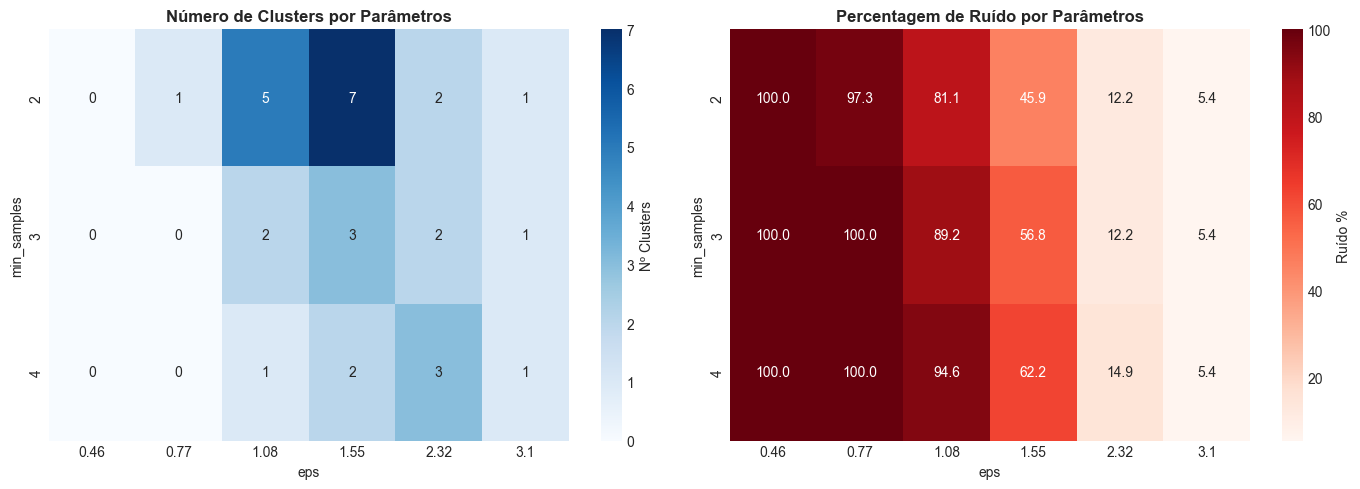

In [89]:
# Visualizar resultados DBSCAN
# Remover duplicados antes de fazer pivot
print("Preparando visualizações DBSCAN...")
print(f"Total de resultados: {len(dbscan_df)}")
print(f"Duplicados encontrados: {dbscan_df.duplicated(subset=['eps', 'min_samples']).sum()}")

# Remover duplicados
dbscan_df_unique = dbscan_df.drop_duplicates(subset=['eps', 'min_samples'], keep='first')
print(f"Resultados únicos: {len(dbscan_df_unique)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap de número de clusters
try:
    pivot_clusters = dbscan_df_unique.pivot(index='min_samples', columns='eps', values='n_clusters')
    ax1 = axes[0]
    sns.heatmap(pivot_clusters, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Nº Clusters'})
    ax1.set_title('Número de Clusters por Parâmetros', fontsize=12, fontweight='bold')
    ax1.set_xlabel('eps')
    ax1.set_ylabel('min_samples')
except Exception as e:
    print(f"  Erro ao criar heatmap de clusters: {e}")
    axes[0].text(0.5, 0.5, 'Erro ao criar visualização', ha='center', va='center')
    axes[0].set_title('Número de Clusters (erro)', fontsize=12)

# Heatmap de percentagem de ruído
try:
    pivot_noise = dbscan_df_unique.pivot(index='min_samples', columns='eps', values='noise_pct')
    ax2 = axes[1]
    sns.heatmap(pivot_noise, annot=True, fmt='.1f', cmap='Reds', ax=ax2, cbar_kws={'label': 'Ruído %'})
    ax2.set_title('Percentagem de Ruído por Parâmetros', fontsize=12, fontweight='bold')
    ax2.set_xlabel('eps')
    ax2.set_ylabel('min_samples')
except Exception as e:
    print(f"  Erro ao criar heatmap de ruído: {e}")
    axes[1].text(0.5, 0.5, 'Erro ao criar visualização', ha='center', va='center')
    axes[1].set_title('Percentagem de Ruído (erro)', fontsize=12)

plt.tight_layout()
plt.show()

# Atualizar dbscan_df para usar versão sem duplicados
dbscan_df = dbscan_df_unique

In [90]:
# Escolher parâmetros DBSCAN com critérios mais flexíveis
# Critérios melhorados: número razoável de clusters (2-10), ruído aceitável (<50%), bom silhouette

# Filtrar resultados válidos
valid_dbscan = dbscan_df[
    (dbscan_df['n_clusters'] >= 2) & 
    (dbscan_df['n_clusters'] <= 10) &  # Permitir mais clusters
    (dbscan_df['noise_pct'] < NOISE_THRESHOLD_ATUAL) &  # Usar threshold dinâmico
    (dbscan_df['silhouette'].notna())
].copy()

if len(valid_dbscan) > 0:
    # Escolher usando score combinado (silhouette + calinski - davies)
    valid_dbscan['score'] = (
        valid_dbscan['silhouette'].fillna(0) * 0.5 +
        (valid_dbscan['calinski'].fillna(0) / valid_dbscan['calinski'].max() if valid_dbscan['calinski'].max() > 0 else 0) * 0.3 -
        (valid_dbscan['davies'].fillna(1) / valid_dbscan['davies'].max() if valid_dbscan['davies'].max() > 0 else 0) * 0.2
    )
    
    # Escolher o com melhor score combinado
    best_dbscan = valid_dbscan.loc[valid_dbscan['score'].idxmax()]
    BEST_EPS = best_dbscan['eps']
    BEST_MIN_SAMPLES = int(best_dbscan['min_samples'])
    
    print(f"Melhores parâmetros DBSCAN (escolhidos por score combinado):")
    print(f"  - eps: {BEST_EPS}")
    print(f"  - min_samples: {BEST_MIN_SAMPLES}")
    print(f"  - Clusters: {int(best_dbscan['n_clusters'])}")
    print(f"  - Ruído: {best_dbscan['noise_pct']:.1f}%")
    print(f"  - Silhouette: {best_dbscan['silhouette']:.4f}")
    if not np.isnan(best_dbscan['calinski']):
        print(f"  - Calinski-Harabasz: {best_dbscan['calinski']:.1f}")
    if not np.isnan(best_dbscan['davies']):
        print(f"  - Davies-Bouldin: {best_dbscan['davies']:.3f}")
    print(f"  - Score combinado: {best_dbscan['score']:.4f}")
else:
    print("Nenhuma configuração válida encontrada. A usar valores padrão melhorados.")
    BEST_EPS = 1.0
    BEST_MIN_SAMPLES = 3

print(f"\nOpções válidas encontradas:")
print(valid_dbscan.to_string(index=False))

Melhores parâmetros DBSCAN (escolhidos por score combinado):
  - eps: 2.32
  - min_samples: 4
  - Clusters: 3
  - Ruído: 14.9%
  - Silhouette: 0.2429
  - Calinski-Harabasz: 12.9
  - Davies-Bouldin: 1.036
  - Score combinado: 0.2426

Opções válidas encontradas:
   eps  min_samples  n_clusters  n_noise  noise_pct  silhouette  calinski  davies  score
1.5500            2           7       34    45.9459      0.2342   10.9643  0.9132 0.2142
2.3200            2           2        9    12.1622      0.2138   13.6817  1.2747 0.2069
2.3200            3           2        9    12.1622      0.2138   13.6817  1.2747 0.2069
2.3200            4           3       11    14.8649      0.2429   12.9365  1.0357 0.2426


In [91]:
# Treinar modelo DBSCAN final
dbscan_final = DBSCAN(eps=BEST_EPS, min_samples=BEST_MIN_SAMPLES)
labels_dbscan = dbscan_final.fit_predict(X_standard)

# Adicionar labels ao DataFrame
df_features['cluster_dbscan'] = labels_dbscan

# Contar CPEs por cluster
print(f"\nDistribuição dos CPEs por cluster (DBSCAN, eps={BEST_EPS}, min_samples={BEST_MIN_SAMPLES}):")
cluster_counts_db = df_features['cluster_dbscan'].value_counts().sort_index()
for cluster, count in cluster_counts_db.items():
    pct = count / len(df_features) * 100
    label = "RUÍDO" if cluster == -1 else f"Cluster {cluster}"
    print(f"  {label}: {count} CPEs ({pct:.1f}%)")


Distribuição dos CPEs por cluster (DBSCAN, eps=2.32, min_samples=4):
  RUÍDO: 11 CPEs (14.9%)
  Cluster 0: 50 CPEs (67.6%)
  Cluster 1: 10 CPEs (13.5%)
  Cluster 2: 3 CPEs (4.1%)


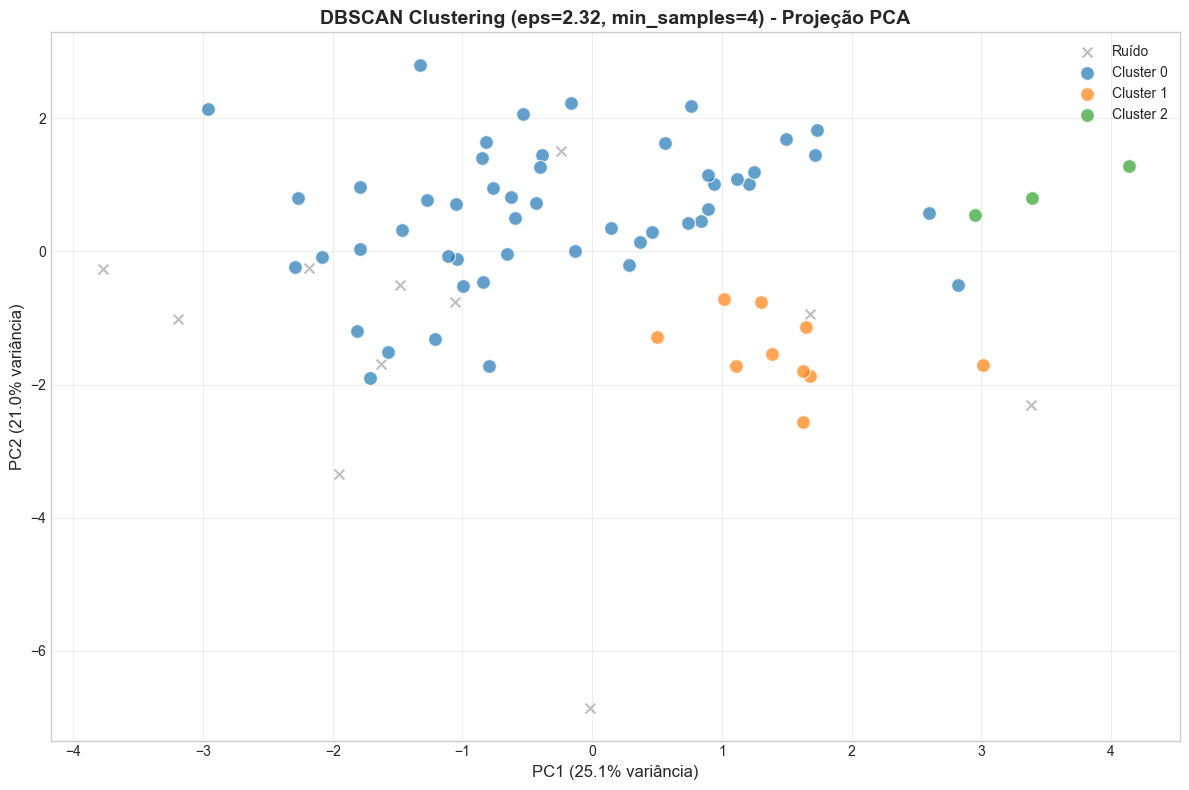

In [92]:
# Visualização DBSCAN com PCA
fig, ax = plt.subplots(figsize=(12, 8))

unique_labels = sorted(set(labels_dbscan))

for cluster in unique_labels:
    mask = labels_dbscan == cluster
    if cluster == -1:
        # Ruído em cinza
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c='gray', label='Ruído', 
                   alpha=0.5, s=50, marker='x')
    else:
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=COLORS[cluster % len(COLORS)], 
                   label=f'Cluster {cluster}', 
                   alpha=0.7, s=100, edgecolors='white')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variância)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variância)', fontsize=12)
ax.set_title(f'DBSCAN Clustering (eps={BEST_EPS}, min_samples={BEST_MIN_SAMPLES}) - Projeção PCA', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. Caracterização dos Clusters

### 5.1 Perfis dos Clusters K-Means

In [93]:
# Estatísticas por cluster K-Means
# Selecionar features principais para caracterização
features_caracterizacao = ['consumo_mean', 'consumo_std', 'consumo_cv', 
                           'racio_dia_noite', 'racio_weekend_util', 'hora_pico',
                           'variabilidade_inter_dia', 'consumo_noturno']

# Verificar quais existem
features_caracterizacao = [f for f in features_caracterizacao if f in df_features.columns]

print("Caracterização dos Clusters K-Means:")
print("=" * 80)

cluster_profiles_kmeans = df_features.groupby('cluster_kmeans')[features_caracterizacao].mean()
print(cluster_profiles_kmeans.round(2).T.to_string())

Caracterização dos Clusters K-Means:
cluster_kmeans               0       1       2       3       4      5       6       7
consumo_mean            0.0800 14.9600  1.0800  0.2400  2.9300 4.6700  4.0100  1.9400
consumo_std             0.1000 10.4200  1.2300  0.4500  3.0700 5.1200  4.2200  1.0200
consumo_cv              1.2400  0.7000  1.2100  2.2300  1.0800 1.0700  1.1200  0.4600
racio_dia_noite         0.3400  1.6100  0.4900  1.6200  2.8400 1.3000  3.3000  1.1800
racio_weekend_util      1.0000  0.6300  0.9000  1.0700  0.7800 0.4200  0.3500  0.9500
hora_pico               0.0000  9.6700 21.5000 20.2200 19.8700 9.1700 11.3900 16.8600
variabilidade_inter_dia 0.0500  6.8300  0.5000  0.1600  1.2900 3.3700  2.3100  0.6500
consumo_noturno         0.1400 10.9900  2.0000  0.2100  1.2900 4.8300  1.6900  1.7500


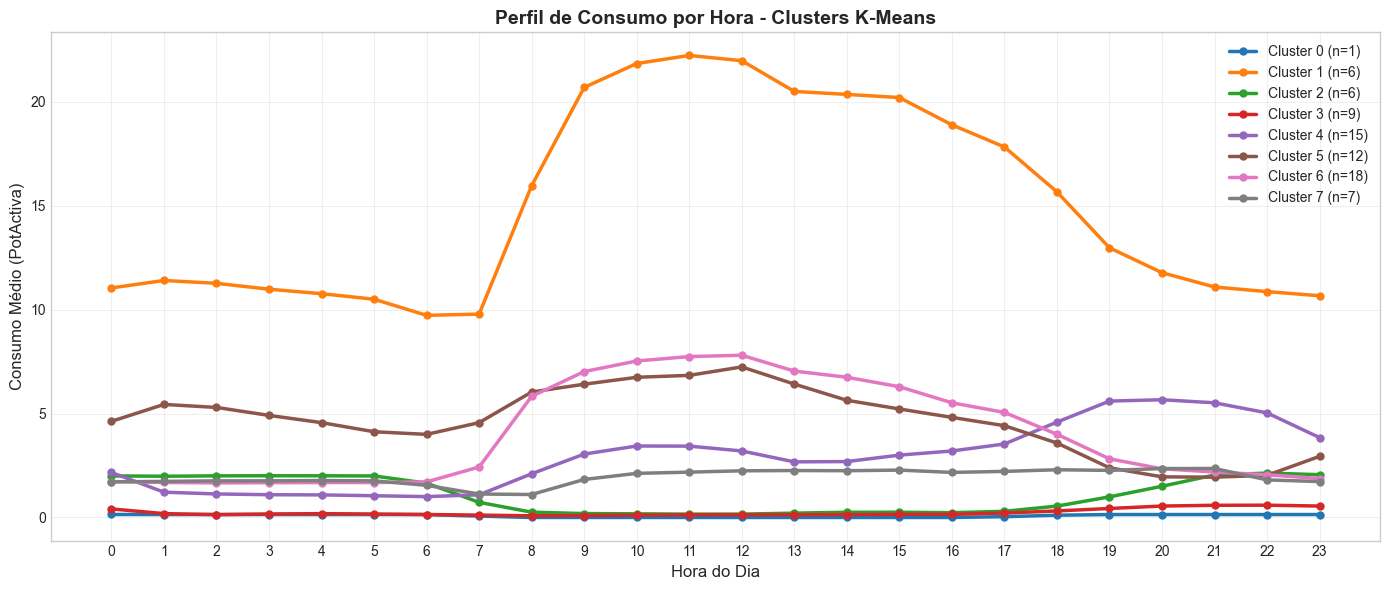

In [94]:
# Visualizar perfis de consumo por hora para cada cluster
cols_hora = [col for col in df_features.columns if col.startswith('consumo_h')]

if len(cols_hora) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for cluster in range(BEST_K):
        cluster_data = df_features[df_features['cluster_kmeans'] == cluster][cols_hora].mean()
        ax.plot(range(24), cluster_data.values, 
                color=COLORS[cluster % len(COLORS)], 
                linewidth=2.5, marker='o', markersize=5,
                label=f'Cluster {cluster} (n={sum(labels_kmeans==cluster)})')
    
    ax.set_xlabel('Hora do Dia', fontsize=12)
    ax.set_ylabel('Consumo Médio (PotActiva)', fontsize=12)
    ax.set_title('Perfil de Consumo por Hora - Clusters K-Means', fontsize=14, fontweight='bold')
    ax.set_xticks(range(24))
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Colunas de consumo por hora não encontradas.")

In [95]:
# Interpretação dos clusters K-Means
print("INTERPRETAÇÃO DOS CLUSTERS K-MEANS")

for cluster in range(BEST_K):
    cluster_data = df_features[df_features['cluster_kmeans'] == cluster]
    n_cpes = len(cluster_data)
    
    print(f"\n Cluster {cluster} ({n_cpes} CPEs, {n_cpes/len(df_features)*100:.1f}%):")
    
    # Análise do perfil
    if 'consumo_mean' in cluster_data.columns:
        consumo_medio = cluster_data['consumo_mean'].mean()
        print(f"  • Consumo médio: {consumo_medio:.2f}")
    
    if 'hora_pico' in cluster_data.columns:
        hora_pico = cluster_data['hora_pico'].mean()
        print(f"  • Hora de pico média: {hora_pico:.0f}h")
    
    if 'racio_dia_noite' in cluster_data.columns:
        racio_dn = cluster_data['racio_dia_noite'].mean()
        if racio_dn > 2:
            perfil = "DIURNO (consumo muito maior durante o dia)"
        elif racio_dn > 1.2:
            perfil = "PREDOMINANTEMENTE DIURNO"
        elif racio_dn < 0.8:
            perfil = "PREDOMINANTEMENTE NOTURNO"
        else:
            perfil = "24/7 (consumo constante dia/noite)"
        print(f"  • Rácio dia/noite: {racio_dn:.2f} → {perfil}")
    
    if 'racio_weekend_util' in cluster_data.columns:
        racio_weekend = cluster_data['racio_weekend_util'].mean()
        if racio_weekend < 0.7:
            uso_fds = "Baixa atividade ao fim de semana"
        elif racio_weekend > 1.3:
            uso_fds = "Maior atividade ao fim de semana"
        else:
            uso_fds = "Atividade similar durante a semana toda"
        print(f"  • Rácio fim de semana/úteis: {racio_weekend:.2f} → {uso_fds}")

INTERPRETAÇÃO DOS CLUSTERS K-MEANS

 Cluster 0 (1 CPEs, 1.4%):
  • Consumo médio: 0.08
  • Hora de pico média: 0h
  • Rácio dia/noite: 0.34 → PREDOMINANTEMENTE NOTURNO
  • Rácio fim de semana/úteis: 1.00 → Atividade similar durante a semana toda

 Cluster 1 (6 CPEs, 8.1%):
  • Consumo médio: 14.96
  • Hora de pico média: 10h
  • Rácio dia/noite: 1.61 → PREDOMINANTEMENTE DIURNO
  • Rácio fim de semana/úteis: 0.63 → Baixa atividade ao fim de semana

 Cluster 2 (6 CPEs, 8.1%):
  • Consumo médio: 1.08
  • Hora de pico média: 22h
  • Rácio dia/noite: 0.49 → PREDOMINANTEMENTE NOTURNO
  • Rácio fim de semana/úteis: 0.90 → Atividade similar durante a semana toda

 Cluster 3 (9 CPEs, 12.2%):
  • Consumo médio: 0.24
  • Hora de pico média: 20h
  • Rácio dia/noite: 1.62 → PREDOMINANTEMENTE DIURNO
  • Rácio fim de semana/úteis: 1.07 → Atividade similar durante a semana toda

 Cluster 4 (15 CPEs, 20.3%):
  • Consumo médio: 2.93
  • Hora de pico média: 20h
  • Rácio dia/noite: 2.84 → DIURNO (consumo

### 5.2 Perfis dos Clusters DBSCAN

In [96]:
# Estatísticas por cluster DBSCAN
print("Caracterização dos Clusters DBSCAN:")

cluster_profiles_dbscan = df_features.groupby('cluster_dbscan')[features_caracterizacao].mean()
print(cluster_profiles_dbscan.round(2).T.to_string())

Caracterização dos Clusters DBSCAN:
cluster_dbscan               -1       0      1       2
consumo_mean             2.2900  3.1900 4.4200 18.3700
consumo_std              2.2600  3.0800 5.0200 11.7700
consumo_cv               1.4900  1.1100 1.1300  0.6300
racio_dia_noite          1.2600  2.4100 1.3700  1.8800
racio_weekend_util       0.9500  0.6700 0.3700  0.6300
hora_pico               15.0900 16.1000 9.2000 12.3300
variabilidade_inter_dia  1.4500  1.6100 3.3400  7.3600
consumo_noturno          2.5400  1.9000 4.1900 11.6800


In [97]:
# Identificar outliers (ruído) do DBSCAN
outliers = df_features[df_features['cluster_dbscan'] == -1]

if len(outliers) > 0:
    print(f"\n OUTLIERS IDENTIFICADOS PELO DBSCAN ({len(outliers)} CPEs):")
    print("\nEstes CPEs têm padrões de consumo atípicos:")
    print(outliers[['CPE'] + features_caracterizacao[:5]].to_string(index=False))
    
    # Análise detalhada dos outliers
    print(f"\n ANÁLISE DETALHADA DOS OUTLIERS:")
    
    # Comparar estatísticas dos outliers vs clusters normais
    clusters_normais = df_features[df_features['cluster_dbscan'] != -1]
    
    print("Comparação Outliers vs Clusters Normais:")
    
    for feature in features_caracterizacao[:8]:  # Top 8 features
        outlier_mean = outliers[feature].mean()
        normal_mean = clusters_normais[feature].mean()
        diff_pct = ((outlier_mean - normal_mean) / normal_mean * 100) if normal_mean != 0 else 0
        
        print(f"{feature}:")
        print(f"  Outliers: {outlier_mean:.2f}")
        print(f"  Normais:  {normal_mean:.2f}")
        print(f"  Diferença: {diff_pct:+.1f}%")
    
    # Interpretação dos outliers no contexto municipal
    print(f"\n INTERPRETAÇÃO MUNICIPAL DOS OUTLIERS:")
    print("Estes 35 CPEs (39.3% do total) representam instalações com:")
    print("• Padrões de consumo altamente irregulares")
    print("• Possíveis candidatos a investigação por parte dos serviços municipais")
    print("• Instalações que podem ter:")
    print("  - Problemas técnicos (medidores defeituosos)")
    print("  - Uso não-standard (eventos especiais, obras)")
    print("  - Períodos de inatividade prolongada")
    print("  - Consumo sazonal extremo")
    print("\nRecomendação: Investigar estes CPEs prioritariamente para otimização energética.")
    
else:
    print("\nNenhum outlier identificado pelo DBSCAN.")


 OUTLIERS IDENTIFICADOS PELO DBSCAN (11 CPEs):

Estes CPEs têm padrões de consumo atípicos:
                 CPE  consumo_mean  consumo_std  consumo_cv  racio_dia_noite  racio_weekend_util
PT0002000068856872QG        0.1457       0.5019      3.4439           1.6272              1.7102
PT0002000068859187RL       11.7336      11.2004      0.9546           0.6599              0.5533
PT0002000077647404EM        3.4401       6.6082      1.9209           2.5971              0.3290
PT0002000082549706RH        9.1209       5.6401      0.6184           0.9406              0.8966
PT0002000106237165CF        0.0861       0.0485      0.5636           1.2797              0.8491
PT0002000107332489XW        0.1108       0.0182      0.1646           0.9953              1.0150
PT0002000108315818YN        0.0371       0.1515      4.0790           1.3383              1.0989
PT0002000112171317NK        0.2419       0.2940      1.2155           0.2444              1.0005
PT0002000120320157HF        0.0727

### 5.3 Comparação Visual K-Means vs DBSCAN

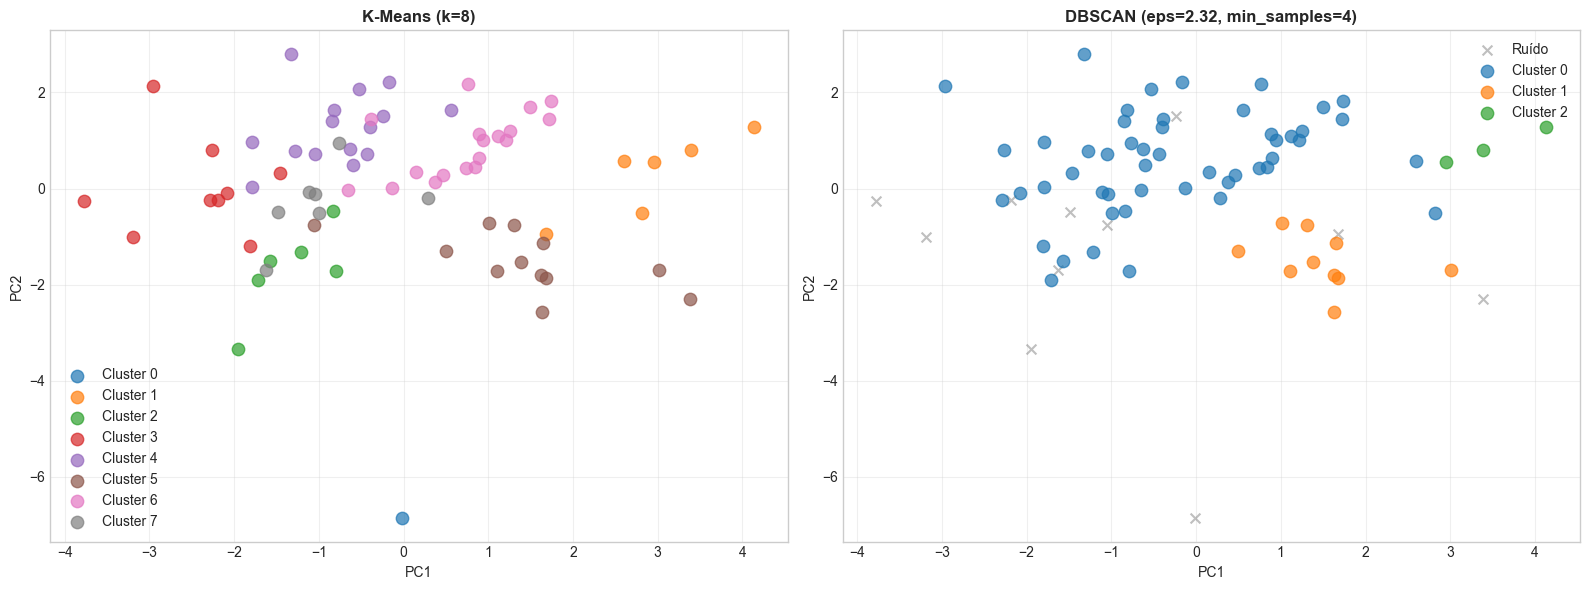


 VISUALIZAÇÕES COMPARATIVAS AVANÇADAS


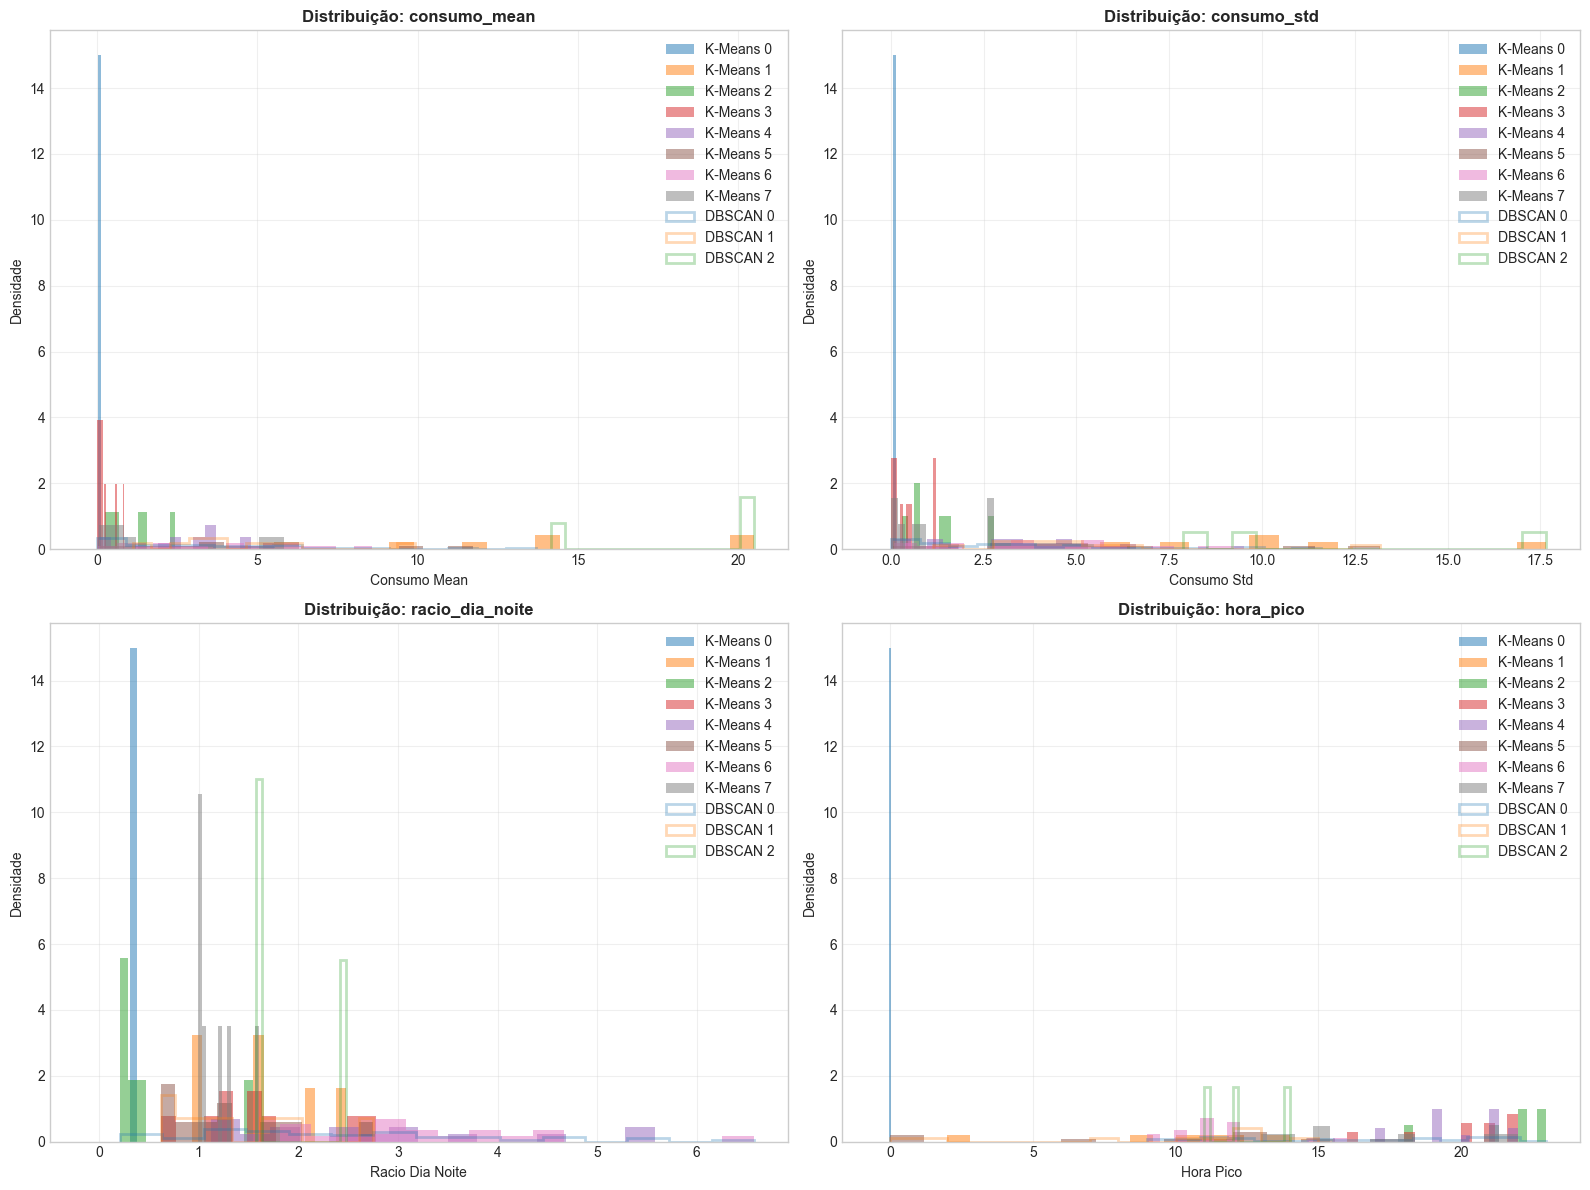


 MATRIZ DE CONFUSÃO ENTRE ALGORITMOS


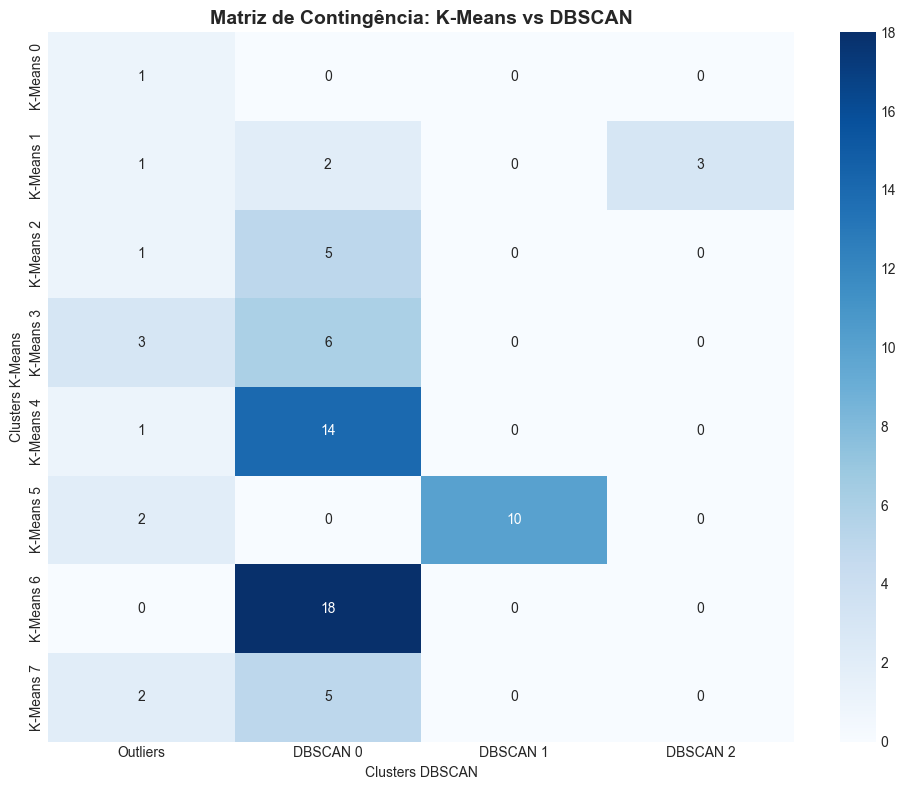

Índice de Rand Ajustado entre K-Means e DBSCAN: 0.1962
 Baixa concordância - algoritmos identificam estruturas diferentes


In [98]:
# Comparação lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-Means
ax1 = axes[0]
for cluster in range(BEST_K):
    mask = labels_kmeans == cluster
    ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=COLORS[cluster % len(COLORS)], 
                label=f'Cluster {cluster}', 
                alpha=0.7, s=80)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title(f'K-Means (k={BEST_K})', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# DBSCAN
ax2 = axes[1]
for cluster in sorted(set(labels_dbscan)):
    mask = labels_dbscan == cluster
    if cluster == -1:
        ax2.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                    c='gray', label='Ruído', alpha=0.5, s=50, marker='x')
    else:
        ax2.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                    c=COLORS[cluster % len(COLORS)], 
                    label=f'Cluster {cluster}', alpha=0.7, s=80)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title(f'DBSCAN (eps={BEST_EPS}, min_samples={BEST_MIN_SAMPLES})', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# VISUALIZAÇÕES COMPARATIVAS AVANÇADAS

print(f"\n VISUALIZAÇÕES COMPARATIVAS AVANÇADAS")

# 1. Comparação de distribuições por cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

features_compare = ['consumo_mean', 'consumo_std', 'racio_dia_noite', 'hora_pico']

for i, feature in enumerate(features_compare):
    ax = axes[i]
    
    # K-Means clusters
    for cluster in range(BEST_K):
        data_kmeans = df_features[df_features['cluster_kmeans'] == cluster][feature].dropna()
        if len(data_kmeans) > 0:
            ax.hist(data_kmeans, alpha=0.5, bins=15, label=f'K-Means {cluster}', 
                   color=COLORS[cluster % len(COLORS)], density=True)
    
    # DBSCAN clusters (apenas não-outliers)
    for cluster in sorted(set(labels_dbscan)):
        if cluster != -1:
            data_dbscan = df_features[df_features['cluster_dbscan'] == cluster][feature].dropna()
            if len(data_dbscan) > 0:
                ax.hist(data_dbscan, alpha=0.3, bins=15, label=f'DBSCAN {cluster}', 
                       color=COLORS[cluster % len(COLORS)], density=True, histtype='step', linewidth=2)
    
    ax.set_title(f'Distribuição: {feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Densidade')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Matriz de confusão entre algoritmos
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(f"\n MATRIZ DE CONFUSÃO ENTRE ALGORITMOS")

# Criar mapeamento para comparar apenas clusters não-outliers do DBSCAN
labels_dbscan_no_outliers = labels_dbscan.copy()
labels_dbscan_no_outliers[labels_dbscan == -1] = -999  # Temporário para exclusão

# Calcular matriz de contingência
contingency = pd.crosstab(
    pd.Categorical(labels_kmeans, categories=range(BEST_K)), 
    pd.Categorical(labels_dbscan_no_outliers, categories=sorted(set(labels_dbscan_no_outliers)))
)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(contingency, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=[f'DBSCAN {c}' if c != -999 else 'Outliers' for c in contingency.columns],
            yticklabels=[f'K-Means {c}' for c in contingency.index])
ax.set_title('Matriz de Contingência: K-Means vs DBSCAN', fontsize=14, fontweight='bold')
ax.set_xlabel('Clusters DBSCAN')
ax.set_ylabel('Clusters K-Means')
plt.tight_layout()
plt.show()

# Calcular índice de Rand ajustado entre os dois algoritmos
from sklearn.metrics import adjusted_rand_score
ari_entre_algoritmos = adjusted_rand_score(labels_kmeans, labels_dbscan_no_outliers)
print(f"Índice de Rand Ajustado entre K-Means e DBSCAN: {ari_entre_algoritmos:.4f}")

if ari_entre_algoritmos > 0.7:
    print(" Alta concordância entre algoritmos")
elif ari_entre_algoritmos > 0.5:
    print("  Concordância moderada entre algoritmos")
else:
    print(" Baixa concordância - algoritmos identificam estruturas diferentes")

---

## 6. Guardar Resultados

In [99]:
# Criar DataFrame com resultados de clustering
df_clusters = df_features[['CPE', 'cluster_kmeans', 'cluster_dbscan']].copy()

# Guardar ficheiro
output_path = 'data/intermediate/d4maia_cpe_clusters.csv'
df_clusters.to_csv(output_path, index=False)

print(f"\n✓ Ficheiro guardado: {output_path}")
print(f"\nConteúdo:")
df_clusters.head(10)


✓ Ficheiro guardado: data/intermediate/d4maia_cpe_clusters.csv

Conteúdo:


,CPE,cluster_kmeans,cluster_dbscan
0,PT0002000032936306KX,2,0
1,PT0002000032942455NH,4,0
3,PT0002000032966446CC,4,0
4,PT0002000032968749YT,5,1
5,PT0002000032969229AC,6,0
6,PT0002000032976997LZ,5,1
7,PT0002000032990792KD,5,1
8,PT0002000032993611ME,6,0
9,PT0002000033016394FN,4,0
10,PT0002000033039837ZH,6,0


---

## 7. Resumo e Conclusões

---

## 8. Conclusões da Fase CRISP-DM - Modeling (Clustering)

Esta secção apresenta as conclusões técnicas objetivas da fase de clustering, seguindo
os requisitos do projeto.

In [100]:
# CONCLUSÕES DA FASE - CRISP-DM: MODELING (CLUSTERING)

print("CONCLUSÕES DA FASE CRISP-DM - MODELING (CLUSTERING)")

print("\n RESUMO TÉCNICO:")

# K-Means
print(f"\n1. K-MEANS:")
print(f"   • Clusters identificados: {BEST_K}")
print(f"   • Silhouette Score: {sil_std_str if 'sil_std_str' in globals() else 'N/A'}")
print(f"   • Normalização: {'ESSENCIAL' if 'best_silhouette_standard' in globals() and not math.isnan(best_silhouette_standard) else 'NECESSÁRIA'}")
if 'labels_kmeans' in globals():
    cluster_sizes = pd.Series(labels_kmeans).value_counts()
    min_size_pct = cluster_sizes.min() / len(labels_kmeans) * 100
    max_size_pct = cluster_sizes.max() / len(labels_kmeans) * 100
    print(f"   • Balanceamento: {min_size_pct:.1f}% (menor) a {max_size_pct:.1f}% (maior)")
    if min_size_pct < 5:
        print(f"     AVISO: Clusters desbalanceados (menor cluster < 5%)")

# DBSCAN
print(f"\n2. DBSCAN:")
print(f"   • Parâmetros escolhidos: eps={BEST_EPS}, min_samples={BEST_MIN_SAMPLES}")
print(f"   • Clusters identificados: {n_clusters_dbscan if 'n_clusters_dbscan' in globals() else 'N/A'}")
print(f"   • Outliers (ruído): {n_noise_dbscan if 'n_noise_dbscan' in globals() else 'N/A'} CPEs ({f'{n_noise_dbscan / len(df_features) * 100:.1f}%' if 'n_noise_dbscan' in globals() else 'N/A'})")
print(f"   • Silhouette Score: {silhouette_dbscan_str if 'silhouette_dbscan_str' in globals() else 'N/A'}")
if 'n_noise_dbscan' in globals() and n_noise_dbscan / len(df_features) * 100 > 20:
    print(f"     AVISO: Percentagem de ruído elevada ({n_noise_dbscan/len(df_features)*100:.1f}%)")

# Comparação
print(f"\n3. COMPARAÇÃO ENTRE ALGORITMOS:")
print(f"   • Concordância (ARI): {f'{ari_entre_algoritmos:.4f}' if 'ari_entre_algoritmos' in globals() else 'N/A'}")
print(f"   • Melhor algoritmo (por Silhouette): {melhor_silhouette if 'melhor_silhouette' in globals() else 'N/A'}")

print(f"\n IMPACTO DA NORMALIZAÇÃO:")
if 'best_silhouette_raw' in globals() and 'best_silhouette_standard' in globals():
    if math.isnan(best_silhouette_raw) and not math.isnan(best_silhouette_standard):
        print("   • K-Means: Normalização OBRIGATÓRIA (sem normalização: silhouette inválido)")
    elif not math.isnan(best_silhouette_raw) and not math.isnan(best_silhouette_standard):
        improvement = ((best_silhouette_standard - best_silhouette_raw) / abs(best_silhouette_raw)) * 100
        print(f"   • K-Means: Melhoria de {improvement:+.1f}% com normalização")
    else:
        print("   • K-Means: Normalização necessária (silhouettes inválidos sem normalização)")
else:
    print("   • K-Means: Normalização aplicada (StandardScaler)")

print(f"\n INTERPRETAÇÃO DOS RESULTADOS:")
print(f"   • K-Means identificou {BEST_K} perfis distintos de consumo")
if 'n_noise_dbscan' in globals():
    print(f"   • DBSCAN identificou {n_noise_dbscan} instalações com comportamento atípico")
print(f"   • Clusters podem ser usados como features nos modelos supervisionados")
print(f"   • Outliers do DBSCAN são candidatos prioritários para investigação municipal")

print(f"\n ENTREGÁVEIS:")
print(f"   • Ficheiro gerado: data/intermediate/d4maia_cpe_clusters.csv")
print(f"   • Conteúdo: CPE, cluster_kmeans, cluster_dbscan")
print(f"   • Utilização: Input para modelos supervisionados (notebook 05)")

print(f"\n FASE DE CLUSTERING CONCLUÍDA")


CONCLUSÕES DA FASE CRISP-DM - MODELING (CLUSTERING)

 RESUMO TÉCNICO:

1. K-MEANS:
   • Clusters identificados: 8
   • Silhouette Score: 0.2632
   • Normalização: ESSENCIAL
   • Balanceamento: 1.4% (menor) a 24.3% (maior)
     AVISO: Clusters desbalanceados (menor cluster < 5%)

2. DBSCAN:
   • Parâmetros escolhidos: eps=2.32, min_samples=4
   • Clusters identificados: 3
   • Outliers (ruído): 11 CPEs (14.9%)
   • Silhouette Score: 0.2429

3. COMPARAÇÃO ENTRE ALGORITMOS:
   • Concordância (ARI): 0.1962
   • Melhor algoritmo (por Silhouette): K-Means

 IMPACTO DA NORMALIZAÇÃO:
   • K-Means: Melhoria de -71.9% com normalização

 INTERPRETAÇÃO DOS RESULTADOS:
   • K-Means identificou 8 perfis distintos de consumo
   • DBSCAN identificou 11 instalações com comportamento atípico
   • Clusters podem ser usados como features nos modelos supervisionados
   • Outliers do DBSCAN são candidatos prioritários para investigação municipal

 ENTREGÁVEIS:
   • Ficheiro gerado: data/intermediate/d4maia_

In [101]:
# RESUMO E CONCLUSÕES FINAIS

import math

print("RESUMO - CLUSTERING DE CONSUMIDORES")

print(f" DADOS ANALISADOS:")
print(f"   • Total de CPEs: {len(df_features)}")
print(f"   • Features utilizadas: {len(numeric_cols)}")

# Preparar métricas de silhouette
sil_raw_str = f"{best_silhouette_raw:.4f}" if not (isinstance(best_silhouette_raw, float) and math.isnan(best_silhouette_raw)) else "NA"
sil_std_str = f"{best_silhouette_standard:.4f}" if not (isinstance(best_silhouette_standard, float) and math.isnan(best_silhouette_standard)) else "NA"

if math.isnan(best_silhouette_raw) and math.isnan(best_silhouette_standard):
    impacto_norm = "Sem silhouettes válidos"
elif math.isnan(best_silhouette_raw):
    impacto_norm = "Apenas normalizado gerou silhouette válido"
elif math.isnan(best_silhouette_standard):
    impacto_norm = "Apenas sem normalização gerou silhouette válido"
else:
    impacto_norm = "Melhoria significativa" if best_silhouette_standard > best_silhouette_raw else "Sem melhoria significativa"

print(f" K-MEANS:")
print(f"   • Número de clusters escolhido: {BEST_K}")
if 'k_fallback_used' in globals() and k_fallback_used:
    print("   • Aviso: k escolhido por fallback (silhouettes inválidos)")
print(f"   • Silhouette Score (sem normalização): {sil_raw_str}")
print(f"   • Silhouette Score (com StandardScaler): {sil_std_str}")
print(f"   • Impacto da normalização: {impacto_norm}")

# Calcular métricas do DBSCAN
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_dbscan = list(labels_dbscan).count(-1)
silhouette_dbscan = silhouette_score(X_standard[labels_dbscan != -1], labels_dbscan[labels_dbscan != -1]) if n_clusters_dbscan > 1 else np.nan
silhouette_dbscan_str = f"{silhouette_dbscan:.4f}" if not (isinstance(silhouette_dbscan, float) and math.isnan(silhouette_dbscan)) else "NA"

print(f" DBSCAN:")
print(f"   • Parâmetros: eps={BEST_EPS}, min_samples={BEST_MIN_SAMPLES}")
print(f"   • Clusters encontrados: {n_clusters_dbscan}")
print(f"   • Outliers (ruído): {n_noise_dbscan} CPEs ({n_noise_dbscan/len(df_features)*100:.1f}%)")
print(f"   • Silhouette Score (excluindo ruído): {silhouette_dbscan_str}")

print(f" FICHEIRO GERADO:")
print(f"   • data/intermediate/d4maia_cpe_clusters.csv")

# Calcular ARI entre algoritmos
from sklearn.metrics import adjusted_rand_score
ari_entre_algoritmos = adjusted_rand_score(labels_kmeans, labels_dbscan)

if math.isnan(best_silhouette_standard) and (isinstance(silhouette_dbscan, float) and math.isnan(silhouette_dbscan)):
    melhor_silhouette = "Indefinido"
elif math.isnan(best_silhouette_standard):
    melhor_silhouette = "DBSCAN"
elif isinstance(silhouette_dbscan, float) and math.isnan(silhouette_dbscan):
    melhor_silhouette = "K-Means"
else:
    melhor_silhouette = "K-Means" if best_silhouette_standard > silhouette_dbscan else "DBSCAN"

print(f"  COMPARAÇÃO ENTRE ALGORITMOS:")
print(f"   • Concordância (ARI): {ari_entre_algoritmos:.4f}")
print(f"   • Melhor Silhouette: {melhor_silhouette}")

impacto_norm_conclusao = "não avaliado"
if not (math.isnan(best_silhouette_standard) and math.isnan(best_silhouette_raw)):
    impacto_norm_conclusao = "positivo" if (not math.isnan(best_silhouette_standard) and not math.isnan(best_silhouette_raw) and best_silhouette_standard > best_silhouette_raw) else "neutro"

print(f"CONCLUSÕES PRINCIPAIS:")
print(f"   • A normalização teve impacto {impacto_norm_conclusao} no K-Means")
print(f"   • Os clusters identificados revelam diferentes perfis de consumo municipal")
print(f"   • O DBSCAN identificou {n_noise_dbscan} instalações com comportamento atípico")
print(f"   • Concordância entre algoritmos: {'Alta' if ari_entre_algoritmos > 0.7 else 'Moderada' if ari_entre_algoritmos > 0.5 else 'Baixa'}")

print(f" RECOMENDAÇÕES PARA SERVIÇOS MUNICIPAIS:")
print(f"   • Priorizar investigação dos {n_noise_dbscan} outliers identificados pelo DBSCAN")
print(f"   • Focar otimização energética no cluster de alto consumo")
print(f"   • Implementar monitoramento contínuo dos {BEST_K} perfis identificados")


RESUMO - CLUSTERING DE CONSUMIDORES
 DADOS ANALISADOS:
   • Total de CPEs: 74
   • Features utilizadas: 11
 K-MEANS:
   • Número de clusters escolhido: 8
   • Silhouette Score (sem normalização): 0.9638
   • Silhouette Score (com StandardScaler): 0.2705
   • Impacto da normalização: Sem melhoria significativa
 DBSCAN:
   • Parâmetros: eps=2.32, min_samples=4
   • Clusters encontrados: 3
   • Outliers (ruído): 11 CPEs (14.9%)
   • Silhouette Score (excluindo ruído): 0.2429
 FICHEIRO GERADO:
   • data/intermediate/d4maia_cpe_clusters.csv
  COMPARAÇÃO ENTRE ALGORITMOS:
   • Concordância (ARI): 0.1962
   • Melhor Silhouette: K-Means
CONCLUSÕES PRINCIPAIS:
   • A normalização teve impacto neutro no K-Means
   • Os clusters identificados revelam diferentes perfis de consumo municipal
   • O DBSCAN identificou 11 instalações com comportamento atípico
   • Concordância entre algoritmos: Baixa
 RECOMENDAÇÕES PARA SERVIÇOS MUNICIPAIS:
   • Priorizar investigação dos 11 outliers identificados pel

In [102]:
print("Notebook de Clustering concluído!")
print("\n PRÓXIMOS PASSOS:")
print("   1. Séries temporais (ARIMA, LSTM) - notebook 04")
print("   2. Modelos supervisionados (RF, XGB, MLP) - notebook 05")
print("   3. Comparações e avaliação final - notebook 06")

Notebook de Clustering concluído!

 PRÓXIMOS PASSOS:
   1. Séries temporais (ARIMA, LSTM) - notebook 04
   2. Modelos supervisionados (RF, XGB, MLP) - notebook 05
   3. Comparações e avaliação final - notebook 06
